In [246]:
import pandas as pd
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from numpy.linalg import inv
from scipy.stats import norm
import scipy.integrate
from scipy.optimize import root_scalar, minimize
import scipy.io as sio
from numba import jit
from pandas.plotting import table

# Table of Contents:
    
   * [1. Functions for Structural Model and Estimation](#structural)
       * [1.1. Parameter and Model Estimation](#estimation)
       * [1.2. Tables and Figures](#tables)
   * [2. Sensitivity Analysis (Andrews et al., 2017)](#sensitivity)
   * [3. Local Partial-Derivative-Based Sensitivity Analysis](#extension)

---
# 1. Functions for Structural Model and Estimation <a class="anchor" id="structural"></a>
---

In [2]:
def ustarDiff(a, paramVector): 
    """Calculates utility of contacted household compared to no solicitation, no flyer case
    Args:
        paramVector (np.array): np.array([S, gs, Gi, mu, sigma])
        a  (array): altruism parameter
    """
    S = paramVector[0]
    gs = paramVector[1]
    Gi = paramVector[2]
    
    if S < 1:
        aMinMin = (1 - S) * Gi
        aMin = (1 - S) * (Gi + gs)
        aPlus = Gi + gs
    else:
        aMinMin = (1 - S) * Gi
        aMin = (1 - S) * Gi * np.exp(-gs)
        aPlus = Gi + gs
    
    g = np.matlib.repmat([999], 1, 
                         len([a]))
    udiff = np.matlib.repmat([999], 1, len([a]))
    
    for i in range(0, len(g)):
        
        if [a][i] <= aMinMin:
            g[0, i] = 0
        elif [a][i] <= aMin:
            g[0, i] = ([a][i] / (1 - S)) - Gi
        elif [a][i] <= aPlus:
            g[0, i] = gs
        else:
            g[0, i] = [a][i] - Gi
            
        #udiff[0, i] = -g[0, i] + [a][i] * np.log(g[0, i] + Gi) - S * (gs - g[0, i]) * (g[0, i] < gs) - [a][i] * np.log(Gi)
        udiff = -g[0, i] + [a][i] * np.log(g[0, i] + Gi) - S * (gs - g[0, i]) * (g[0, i] < gs) - [a][i] * np.log(Gi)
    
    return udiff 

In [3]:
def giversAvgUtilBenchmark(parameters):
    """Calculates Average Utility per household in the no-flyer case 
       compared to no solicitation, in the benchmark model.
    Args:
        parameters (np.array): estimates
    """
    N = 15
    h_0 = parameters[0]
    r = parameters[1]
    eta = parameters[2]
    mu_lar = parameters[3]
    mu_ecu = parameters[4]
    mu_s = parameters[5]
    sigma_lar = parameters[6]
    sigma_ecu = parameters[7]
    sigma_s =  parameters[8]
    S_lar = parameters[9]
    S_ecu = parameters[10]
    S_svy = parameters[11]
    timeval = parameters[12]
    Gi_lar = parameters[13]
    Gi_ecu = Gi_lar
    gs_lar = 10
    gs_ecu = 10
    
    if sum(parameters[np.r_[0:3, 6:14]] < 0) > 0:
        f = np.matlib.repmat(np.nan, 2, 1)
        return f
    if sum(parameters[0:2] > 1) > 0:
        f = np.matlib.repmat(np.nan, 2, 1)
        return f
    
    paramVector_lar = np.array([S_lar, gs_lar, Gi_lar, mu_lar, sigma_lar])
    paramVector_ecu = np.array([S_ecu, gs_ecu, Gi_ecu, mu_ecu, sigma_ecu])
    
    if (S_lar < 1):
        aMinMin_lar = (1 - S_lar)*Gi_lar
        aMin_lar = (1 - S_lar)* (Gi_lar + gs_lar)
        aPlus_lar = Gi_lar + gs_lar
        a0_lar = gs_lar / np.log(1 + (gs_lar/Gi_lar))
    else:
        aMinMin_lar = -(S_lar - 1) * gs_lar/(Gi_lar * np.log(1 + (gs_lar/Gi_lar)) + gs_lar * (np.log(Gi_lar + gs_lar) - 1))
        aMin_lar = aMinMin_lar
        aPlus_lar = Gi_lar + gs_lar
        
    # For ECU
    if (S_ecu < 1):
        aMinMin_ecu = (1 - S_ecu)*Gi_ecu
        aMin_ecu = (1 - S_ecu)* (Gi_ecu + gs_ecu)
        aPlus_ecu = Gi_ecu + gs_ecu
        
    else:
        aMinMin_ecu = -(S_ecu - 1) * gs_ecu/(Gi_ecu * np.log(1 + (gs_ecu/Gi_ecu)) + gs_ecu * (np.log(Gi_ecu + gs_ecu) - 1))
        aMin_ecu = aMinMin_ecu
        aPlus_ecu = Gi_ecu + gs_ecu
        
    U_lar_quadl = scipy.integrate.quad(lambda x, y: ustarDiff(x, y) * norm.pdf(x, mu_lar, sigma_lar), 
                                       mu_lar - 5 * sigma_lar,
                                       mu_lar + 5 * sigma_lar, args=(paramVector_lar, ))[0] * h_0
    U_ecu_quadl = scipy.integrate.quad(lambda x, y: ustarDiff(x, y) * norm.pdf(x, mu_ecu, sigma_ecu), 
                                       mu_ecu - 5 * sigma_ecu,
                                       mu_ecu + 5 * sigma_ecu, args=(paramVector_ecu, ))[0] * h_0
    
    f = np.array([U_lar_quadl, U_ecu_quadl]).T
    return f

In [4]:
def ustarDiffFlyer(a, paramVector):
    """Calculates the difference in utility 
       from no solicitation in the flyer treatment, 
       for someone who sees the flyer.
    Args:
        paramVector (np.array): np.array([S, gs, Gi, mu, sigma])
        a  (array): altruism parameter
    """
    h_0 = paramVector[0]
    eta = paramVector[1]
    S = paramVector[2]
    gs = paramVector[3]
    Gi = paramVector[4]
    
    
    if S < 1:
        aMinMin = (1 - S) * Gi
        aMin = (1 - S) * (Gi + gs)
        aPlus = Gi + gs
    else:
        aMinMin = -(S - 1) * gs / (Gi * np.log(1 + (gs/Gi)) + gs * (np.log(Gi + gs) - 1))
        aMin = aMinMin
        aPlus = Gi + gs
    
    g = np.matlib.repmat([999], 1, 
                         len([a]))
    h = np.matlib.repmat([999], 1, 
                         len([a]))
    udiff = np.matlib.repmat([999], 1, len([a]))
    
    for i in range(0, len(g)):
        
        if a <= aMinMin:
            g = 0
            h = h_0 - eta * S * gs
        elif a <= aMin:
            g = (a / (1 - S)) - Gi
            h = h_0 + eta * (a * np.log(a/(1-S)) - a * (1 + np.log(Gi)) - S * gs + Gi * (1 - S))
        elif a <= aPlus:
            g = gs
            h = h_0 + eta * (a * np.log(1 + (gs/Gi)) - gs)
        else:
            g = a - Gi
            h = h_0 + eta * (Gi - a + a * np.log(a/Gi))
       
        h = max(0, min(1, h))
        udiff = h * (-g + a * np.log(g + Gi) - S * (gs - g) * (g < gs) - \
                           a * np.log(Gi)) - ((h_0 - h)**2) / (2 * eta)
        
    
    return udiff 
    

In [5]:
def giversAvgUtilFlyerRBenchmark(parameters):
    """Calculates the Average Utility of people 
       contacted in the flyer treatment, who
       observe the flyer.
    Args:
        parameters  (np.array): estimates
    """
    N = 15
    h_0 = parameters[0]
    r = parameters[1]
    eta = parameters[2]
    mu_lar = parameters[3]
    mu_ecu = parameters[4]
    mu_s = parameters[5]
    sigma_lar = parameters[6]
    sigma_ecu = parameters[7]
    sigma_s =  parameters[8]
    S_lar = parameters[9]
    S_ecu = parameters[10]
    S_svy = parameters[11]
    timeval = parameters[12]
    Gi_lar = parameters[13]
    Gi_ecu = Gi_lar
    gs_lar = 10
    gs_ecu = 10
    
    
    if sum(parameters[np.r_[0:3, 6:14]] < 0) > 0:
        f = np.matlib.repmat(np.nan, 2, 1)
        return f
    if sum(parameters[0:2] > 1) > 0:
        f = np.matlib.repmat(np.nan, 2, 1)
        return f
    
    # Altruism Cut-off values for LAR
    if (S_lar < 1):
        aMinMin_lar = (1 - S_lar)*Gi_lar
        aMin_lar = (1 - S_lar)* (Gi_lar + gs_lar)
        aPlus_lar = Gi_lar + gs_lar
        a0_lar = gs_lar / np.log(1 + (gs_lar/Gi_lar))
    else:
        aMinMin_lar = -(S_lar - 1) * gs_lar/(Gi_lar * np.log(1 + (gs_lar/Gi_lar)) + gs_lar * (np.log(Gi_lar + gs_lar) - 1))
        aMin_lar = aMinMin_lar
        aPlus_lar = Gi_lar + gs_lar
        
    # For ECU
    if (S_ecu < 1):
        aMinMin_ecu = (1 - S_ecu)*Gi_ecu
        aMin_ecu = (1 - S_ecu)* (Gi_ecu + gs_ecu)
        aPlus_ecu = Gi_ecu + gs_ecu
        
    else:
        aMinMin_ecu = -(S_ecu - 1) * gs_ecu/(Gi_ecu * np.log(1 + (gs_ecu/Gi_ecu)) + gs_ecu * (np.log(Gi_ecu + gs_ecu) - 1))
        aMin_ecu = aMinMin_ecu
        aPlus_ecu = Gi_ecu + gs_ecu
        
    paramVector_lar = np.array([h_0, eta, S_lar, gs_lar, Gi_lar, aMinMin_lar, aMin_lar, aPlus_lar])
    paramVector_ecu = np.array([h_0, eta, S_ecu, gs_ecu, Gi_ecu, aMinMin_ecu, aMin_ecu, aPlus_ecu])
        
    # Caluclate utility by integrating over ustarDiff    
    U_lar_quadl = scipy.integrate.quad(lambda x, y: ustarDiffFlyer(x, y) * norm.pdf(x, mu_lar, sigma_lar), 
                                       mu_lar - 5 * sigma_lar,
                                       mu_lar + 5 * sigma_lar, args=(paramVector_lar, ))[0] 
    U_ecu_quadl = scipy.integrate.quad(lambda x, y: ustarDiffFlyer(x, y) * norm.pdf(x, mu_ecu, sigma_ecu), 
                                       mu_ecu - 5 * sigma_ecu,
                                       mu_ecu + 5 * sigma_ecu, args=(paramVector_ecu, ))[0] 
    
    f = np.array([U_lar_quadl, U_ecu_quadl]).T
    
    return f

In [6]:
def giversAvgUtilFlyerBenchmark(parameters):
    """Calculates the Average Utility of people 
       contacted in the flyer case compared to 
       no solicitation in the benchmark model.
    Args:
        parameters  (np.array): estimates
    """
    
    r = parameters[1]
    if sum(parameters[np.r_[0:3, 6:15]] < 0) > 0:
        f = np.matlib.repmat(np.nan, 2, 1)
        return f
    if sum(parameters[0:2]>1)>0:
        f = np.matlib.repmat(np.nan, 2, 1)
        return f
    U_quadl = r * giversAvgUtilFlyerRBenchmark(parameters) + (1 - r) * giversAvgUtilBenchmark(parameters)
    
    f = np.array([U_quadl[0], U_quadl[1]]).T
    return f

In [7]:
def ustarDiffOptOut(a, paramVector):
    """Caclulates the  Difference in the 
       utility of a contacted household 
       compared to no solicitation 
       in the opt-out treatment
    Args:
        paramVector (np.array): np.array([S, gs, Gi, mu, sigma])
        a  (array): altruism parameter
       """
    h_0 = paramVector[0]
    eta = paramVector[1]
    S = paramVector[2]
    gs = paramVector[3]
    Gi = paramVector[4]
    epsilon = 10**(-5)
    
    if (S < 1):
        aMinMin = (1 -S) * Gi
        aMin = (1 - S) * (Gi + gs)
        aPlus = Gi + gs
        if (S == 0):
            a0 = aMinMin
        else:
            a0 = gs / np.log(1 + (gs/Gi))
            if ((a0 < aMin) | (a0 > aPlus)):
                def func(a0):
                    f = a0 * np.log(a0 / (Gi * (1 - S))) - a0 + Gi * (1 - S) - S * gs
                    return f
                sol = root_scalar(func, method='toms748', bracket=[aMinMin - epsilon, aMin + epsilon])
                a0 = sol.root
    else:
        aMinMin = -(S - 1) * gs / (Gi * np.log(1 + (gs/Gi)) + gs * (np.log(Gi + gs) - 1))
        aMin = aMinMin
        aPlus = Gi + gs
        a0 = gs / np.log(1 + (gs / Gi))
        
    if (S == 0):
        aOO = float('-inf')
    else:
        aOO = a0
    
    g = np.matlib.repmat([999], 1, 
                         len([a]))
    h = np.matlib.repmat([999], 1, 
                         len([a]))
    udiff = np.matlib.repmat([999], 1, len([a]))
    
    for i in range(0, len(g)):
        
        if [a][i] <= aMinMin:
            g[0, i] = 0
            h[0, i] = h_0 - eta * S * gs
        elif [a][i] <= aMin:
            g[0, i] = ([a][i] / (1 - S)) - Gi
            h[0, i] = h_0 + eta * ([a][i] * np.log([a][i]/(1-S)) - [a][i] * (1 + np.log(Gi)) - S * gs + Gi * (1 - S))
        elif [a][i] <= aPlus:
            g[0, i] = gs
            h[0, i] = h_0 + eta * ([a][i] * np.log(1 + (gs/Gi)) - gs)
        else:
            g[0, i] = [a][i] - Gi
            h[0, i] = h_0 + eta * (Gi - [a][i] + [a][i] * np.log([a][i]/Gi))
       
        h[0, i] = max(0, min(1, h[0, i]))
        if ([a][i] <= aOO):
            udiff = 0
        else:
            udiff = h[0, i] * (-g[0, i] + [a][i] * np.log(g[0, i] + Gi) - S * (gs - g[0, i]) * (g[0, i] < gs) - \
                           [a][i] * np.log(Gi)) - ((h_0 - h[0, i])**2) / (2 * eta)
    
    return udiff

In [8]:
def giversAvgUtilOptOutBenchmark(parameters):
    """Calculates the Average Utility 
       per household in the opt-out case.
    Args:
        parameters  (np.array): estimates
    """
    N = 15
    h_0 = parameters[0]
    r = parameters[1]
    eta = parameters[2]
    mu_lar = parameters[3]
    mu_ecu = parameters[4]
    mu_s = parameters[5]
    sigma_lar = parameters[6]
    sigma_ecu = parameters[7]
    sigma_s =  parameters[8]
    S_lar = parameters[9]
    S_ecu = parameters[10]
    S_svy = parameters[11]
    timeval = parameters[12]
    Gi_lar = parameters[13]
    Gi_ecu = Gi_lar
    gs_lar = 10
    gs_ecu = 10
    
    if sum(parameters[np.r_[0:3, 6:14]] < 0) > 0:
        f = np.matlib.repmat(np.nan, 2, 1)
        return f
    if sum(parameters[0:2] > 1) > 0:
        f = np.matlib.repmat(np.nan, 2, 1)
        return f
    
    # Altruism Cut-off values for LAR
    if (S_lar < 1):
        aMinMin_lar = (1 - S_lar)*Gi_lar
        aMin_lar = (1 - S_lar)* (Gi_lar + gs_lar)
        aPlus_lar = Gi_lar + gs_lar
        a0_lar = gs_lar / np.log(1 + (gs_lar/Gi_lar))
    else:
        aMinMin_lar = -(S_lar - 1) * gs_lar/(Gi_lar * np.log(1 + (gs_lar/Gi_lar)) + gs_lar * (np.log(Gi_lar + gs_lar) - 1))
        aMin_lar = aMinMin_lar
        aPlus_lar = Gi_lar + gs_lar
        
    # For ECU
    if (S_ecu < 1):
        aMinMin_ecu = (1 - S_ecu)*Gi_ecu
        aMin_ecu = (1 - S_ecu)* (Gi_ecu + gs_ecu)
        aPlus_ecu = Gi_ecu + gs_ecu
        
    else:
        aMinMin_ecu = -(S_ecu - 1) * gs_ecu/(Gi_ecu * np.log(1 + (gs_ecu/Gi_ecu)) + gs_ecu * (np.log(Gi_ecu + gs_ecu) - 1))
        aMin_ecu = aMinMin_ecu
        aPlus_ecu = Gi_ecu + gs_ecu
        
    paramVector_lar = np.array([h_0, eta, S_lar, gs_lar, Gi_lar, aMinMin_lar, aMin_lar, aPlus_lar])
    paramVector_ecu = np.array([h_0, eta, S_ecu, gs_ecu, Gi_ecu, aMinMin_ecu, aMin_ecu, aPlus_ecu])
        
    # Caluclate utility by integrating over ustarDiff    
    U_lar_quadl = scipy.integrate.quad(lambda x, y: ustarDiffOptOut(x, y) * norm.pdf(x, mu_lar, sigma_lar), 
                                       mu_lar - 5 * sigma_lar,
                                       mu_lar + 5 * sigma_lar, args=(paramVector_lar, ))[0] 
    U_ecu_quadl = scipy.integrate.quad(lambda x, y: ustarDiffOptOut(x, y) * norm.pdf(x, mu_ecu, sigma_ecu), 
                                       mu_ecu - 5 * sigma_ecu,
                                       mu_ecu + 5 * sigma_ecu, args=(paramVector_ecu, ))[0] 
    
    f = np.array([U_lar_quadl, U_ecu_quadl]).T
    return f

In [9]:
def giversAvgUtilOptOutRBenchmark(parameters):
    r = parameters[1]
    if sum(parameters[np.r_[0:3, 6:15]] < 0) > 0:
        f = np.matlib.repmat(np.nan, 2, 1)
        return f
    if sum(parameters[np.r_[0:2, 14]] > 1) > 0:
        f = np.matlib.repmat(np.nan, 2, 1)
        return f
    U_quadl = r * giversAvgUtilOptOutBenchmark(parameters) + (1 - r) * giversAvgUtilBenchmark(parameters)
    
    f = np.array([U_quadl[0], U_quadl[1]]).T
    return f    

In [10]:
def gstar(a, paramVector):
    """Calculates optimal giving
    Args:
        paramVector (np.array): np.array([S, gs, Gi])
        a  (array): altruism parameter 
    """
    S = paramVector[0]
    gs = paramVector[1]
    Gi = paramVector[2]
    
    if (S < 1):
        aMinMin = (1 -S) * Gi
        aMin = (1 - S) * (Gi + gs)
        aPlus = Gi + gs
        a0 = gs / np.log(1 + (gs/Gi))
    else:
        aMinMin = -(S - 1) * gs / (Gi * np.log(1 + (gs/Gi)) + gs * (np.log(Gi + gs) - 1))
        aMin = aMinMin
        aPlus = Gi + gs
    
    g = np.matlib.repmat([999], 1, 
                         len([a]))
    
    for i in range(0, len(g)):
        
        if [a][i] <= aMinMin:
            g[0, i] = 0
        elif [a][i] <= aMin:
            g[0, i] = ([a][i] / (1 - S)) - Gi
        elif [a][i] <= aPlus:
            g[0, i] = gs
        else:
            g[0, i] = [a][i] - Gi
    
    return g  

In [11]:
def givingCompareWithNoPressureBenchmark(parameters):
    """Calculates Levels of giving to a hypothetical 
       scenario without social pressure
    Args:
        parameters  (np.array): estimates
    """
    h_0 = parameters[0]
    r = parameters[1]
    eta = parameters[2]
    mu_lar = parameters[3]
    mu_ecu = parameters[4]
    mu_s = parameters[5]
    sigma_lar = parameters[6]
    sigma_ecu = parameters[7]
    sigma_s =  parameters[8]
    S_lar = parameters[9]
    S_ecu = parameters[10]
    S_svy = parameters[11]
    timeval = parameters[12]
    Gi_lar = parameters[13]
    Gi_ecu = Gi_lar
    gs_lar = 10
    gs_ecu = 10
    
    if sum(parameters[np.r_[0:3, 6:14]] < 0) > 0:
        f = np.matlib.repmat(np.nan, 6, 1)
        return f
    if sum(parameters[0:2] > 1) > 0:
        f = np.matlib.repmat(np.nan, 6, 1)
        return f
    
    paramVector_lar = np.array([S_lar, gs_lar, Gi_lar, mu_lar, sigma_lar])
    paramVector_ecu = np.array([S_ecu, gs_ecu, Gi_ecu, mu_ecu, sigma_ecu])
    paramVectorS0_lar = np.array([0, gs_lar, Gi_lar, mu_lar, sigma_lar])
    paramVectorS0_ecu = np.array([0, gs_ecu, Gi_ecu, mu_ecu, sigma_ecu])
    
    GS_lar_quadl = scipy.integrate.quad(lambda x, y: gstar(x, y) * norm.pdf(x, mu_lar, sigma_lar), 
                                       -1,
                                       mu_lar + 5 * sigma_lar, args=(paramVector_lar, ))[0] * h_0
    GS0_lar_quadl = scipy.integrate.quad(lambda x, y: gstar(x, y) * norm.pdf(x, mu_lar, sigma_lar), 
                                       -1,
                                       mu_ecu + 5 * sigma_ecu, args=(paramVectorS0_lar, ))[0] * h_0
    fracWithoutSoc_lar = GS0_lar_quadl / GS_lar_quadl
    GS_ecu_quadl = scipy.integrate.quad(lambda x, y: gstar(x, y) * norm.pdf(x, mu_ecu, sigma_ecu), 
                                       -1,
                                       mu_lar + 5 * sigma_lar, args=(paramVector_ecu, ))[0] * h_0
    GS0_ecu_quadl = scipy.integrate.quad(lambda x, y: gstar(x, y) * norm.pdf(x, mu_ecu, sigma_ecu), 
                                       -1,
                                       mu_ecu + 5 * sigma_ecu, args=(paramVectorS0_ecu, ))[0] * h_0
    fracWithoutSoc_ecu = GS0_ecu_quadl /  GS_ecu_quadl
    
    f = np.array([GS_lar_quadl, GS0_lar_quadl, fracWithoutSoc_lar, 
                  GS_ecu_quadl, GS0_ecu_quadl, fracWithoutSoc_ecu]).T
    
    return f

In [12]:
def hstar(a, paramVector):
    """Calculate  the optimal 
       probability of being at home
    Args:
        paramVector (np.array): estimates
        a  (array): altruism parameter
    """
    
    h_0 = paramVector[0]
    eta_down = paramVector[1]
    S = paramVector[2]
    gs = paramVector[3]
    Gi = paramVector[4]
    aMinMin = paramVector[5]
    aMin = paramVector[6]
    aPlus = paramVector[7]
    aOO = paramVector[8]
    
    # Allow for assymmetric sorting
    if (len(paramVector) == 12):
        eta_up = paramVector[11]
    else:
        eta_up = eta_down
    
    h = np.matlib.repmat([999], 1, len([a]))
    
    # The optimal probability of being at home
    for i in range(0, len(h)):
        if [a][i] <= aOO:
            eta = eta_down
        else:
            eta = eta_up
        
        if [a][i] <= aMinMin:
            h = h_0 - eta * S * gs
        elif [a][i] <= aMin:
            if [a][i] >= 0:
                h = h_0 + eta * ([a][i] * np.log([a][i]/(1-S)) - [a][i] * (1 + np.log(Gi)) - S * gs + Gi * (1 - S))
            else:
                h[0, i] = h_0 + eta * ((1 - S) * (1 - np.log((1 - S) * Gi / [a][i])) - S * gs - ([a][i] / Gi))
        elif [a][i] <= aPlus:
            if [a][i] >= 0:
                h = h_0 + eta * ([a][i] * np.log(1 + (gs/Gi)) - gs)
            else:
                h = h_0 + eta * (([a][i] / Gi) * (np.exp(gs) - 1) - gs)
        else:
            h = h_0 + eta * (Gi - [a][i] + [a][i] * np.log([a][i]/Gi))
            
        h = max(0, min(1, h))
    
    return h

In [13]:
def hstarOO(a, paramVector):
    """Calculates the Optimal probability 
       of being at home for someone in the 
       opt-out treatment
    Args:
        paramVector (np.array): estimates
        a  (array): altruism parameter
    """
    h_0 = paramVector[0]
    eta = paramVector[1]
    S = paramVector[2]
    gs = paramVector[3]
    Gi = paramVector[4]
    aMinMin = paramVector[5]
    aMin = paramVector[6]
    aPlus = paramVector[7]
    aOO = paramVector[8]
    
    h = np.matlib.repmat([999], 1, len([a]))
    
    # The optimal probability of being at home
    for i in range(0, len(h)):
        if [a][i] <= aMinMin:
            h[0, i] = h_0 - eta * S * gs
        elif [a][i] <= aMin:
            h[0, i] = h_0 + eta * ([a][i] * np.log([a][i]/(1-S)) - [a][i] * (1 + np.log(Gi)) - S * gs + Gi * (1 - S))
        elif [a][i] <= aPlus:
            h[0, i] = h_0 + eta * ([a][i] * np.log(1 + (gs/Gi)) - gs)
        else:
            h[0, i] = h_0 + eta * (Gi - [a][i] + [a][i] * np.log([a][i]/Gi))
        if [a][i] <= aOO:
            h[0, i] = 0
  
        h[0, i] = max(0, min(1, h[0, i]))
    
    return h

In [14]:
def givingFlyer(parameters):
    """Calculate the Average unconditional 
       giving in the flyer treatment
    Args:
        parameters (np.array): estimates
    """
    N = 15
    h_0 = parameters[0]
    r = parameters[1]
    eta = parameters[2]
    mu_lar = parameters[3]
    mu_ecu = parameters[4]
    mu_s = parameters[5]
    sigma_lar = parameters[6]
    sigma_ecu = parameters[7]
    sigma_s =  parameters[8]
    S_lar = parameters[9]
    S_ecu = parameters[10]
    S_svy = parameters[11]
    timeval = parameters[12]
    Gi_lar = parameters[13]
    Gi_ecu = Gi_lar
    gs_lar = 10
    gs_ecu = 10
    
    epsilon = 0.000001
    
    if (S_lar < 1):
        aMinMin_lar = (1 - S_lar)*Gi_lar
        aMin_lar = (1 - S_lar)* (Gi_lar + gs_lar)
        aPlus_lar = Gi_lar + gs_lar
        a0_lar = gs_lar / np.log(1 + (gs_lar/Gi_lar))
        if ((a0_lar < aMin_lar) | (a0_lar > aPlus_lar)):
            def func_lar(a0):
                f = a0 * np.log(a0 / (Gi_lar * (1 - S_lar))) - a0 + Gi_lar * (1 - S_lar) - S_lar * gs_lar
                return f
            sol_lar = root_scalar(func_lar, method='toms748', bracket=[aMinMin_lar - epsilon, aMin_lar + epsilon])
            a0_lar = sol_lar.root
    else:
        aMinMin_lar = (1 - S_lar)*Gi_lar
        aMin_lar = (1 - S_lar)*Gi_lar*np.exp(-gs_lar)
        aPlus_lar = Gi_lar + gs_lar
        a0_lar = gs_lar / np.log(1 + (gs_lar/Gi_lar))
    
    if (S_lar == 0):
        aOO_lar = float('-inf')
    else:
        aOO_lar = a0_lar
    
    # For ECU
    if (S_ecu < 1):
        aMinMin_ecu = (1 - S_ecu)*Gi_ecu
        aMin_ecu = (1 - S_ecu)* (Gi_ecu + gs_ecu)
        aPlus_ecu = Gi_ecu + gs_ecu
        a0_ecu = gs_ecu / np.log(1 + (gs_ecu/Gi_ecu))
        if ((a0_ecu < aMin_ecu) | (a0_ecu > aPlus_ecu)):
            def func_ecu(a0):
                f = a0 * np.log(a0 / (Gi_ecu * (1 - S_ecu))) - a0 + Gi_ecu * (1 - S_ecu) - S_ecu * gs_ecu
                return f
            sol_ecu = root_scalar(func_ecu, method='toms748', bracket=[aMinMin_ecu - epsilon, aMin_ecu + epsilon])
            a0_ecu = sol_ecu.root
    else:
        aMinMin_ecu = (1 - S_ecu)*Gi_ecu
        aMin_ecu = (1 - S_ecu)*Gi_ecu*np.exp(-gs_ecu)
        aPlus_ecu = Gi_ecu + gs_ecu
        a0_ecu = gs_ecu / np.log(1 + (gs_ecu/Gi_ecu))
    
    if (S_ecu == 0):
        aOO_ecu = float('-inf')
    else:
        aOO_ecu = a0_ecu
    
    paramVector_lar = np.array([h_0, eta, S_lar, gs_lar, Gi_lar, aMinMin_lar, aMin_lar, aPlus_lar,
                               aOO_lar, mu_lar, sigma_lar])
    paramVector_ecu = np.array([h_0, eta, S_ecu, gs_ecu, Gi_ecu, aMinMin_ecu, aMin_ecu, aPlus_ecu,
                               aOO_ecu, mu_ecu, sigma_ecu])
        
    # Caluclate utility by integrating 
    G_lar_quadl = scipy.integrate.quad(lambda x, y: hstar(x, y) * gstar(x, y[2:5]) * norm.pdf(x, mu_lar, sigma_lar), 
                                       mu_lar - 5 * sigma_lar,
                                       mu_lar + 5 * sigma_lar, args=(paramVector_lar, ))[0] 
    G_ecu_quadl = scipy.integrate.quad(lambda x, y: hstar(x, y) * gstar(x, y[2:5]) * norm.pdf(x, mu_ecu, sigma_ecu), 
                                       mu_ecu - 5 * sigma_ecu,
                                       mu_ecu + 5 * sigma_ecu, args=(paramVector_ecu, ))[0] 
    
    f = np.array([G_lar_quadl, G_ecu_quadl]).T
    return f

In [15]:
def givingNoFlyer(parameters):
    """Calculates the  Average unconditional 
       giving in the no-flyer treatment
    Args:
        parameters (np.array): estimates
    """
    N = 15
    h_0 = parameters[0]
    r = parameters[1]
    eta = parameters[2]
    mu_lar = parameters[3]
    mu_ecu = parameters[4]
    mu_s = parameters[5]
    sigma_lar = parameters[6]
    sigma_ecu = parameters[7]
    sigma_s =  parameters[8]
    S_lar = parameters[9]
    S_ecu = parameters[10]
    S_svy = parameters[11]
    timeval = parameters[12]
    Gi_lar = parameters[13]
    Gi_ecu = Gi_lar
    gs_lar = 10
    gs_ecu = 10
    
    if (S_lar < 1):
        aMinMin_lar = (1 - S_lar)*Gi_lar
        aMin_lar = (1 - S_lar)* (Gi_lar + gs_lar)
        aPlus_lar = Gi_lar + gs_lar
        a0_lar = gs_lar / np.log(1 + (gs_lar/Gi_lar))
   
    else:
        aMinMin_lar = -(S_lar - 1) * gs_lar / (Gi_lar * np.log(1 + (gs_lar/Gi_lar)) + gs_lar * (np.log(Gi_lar + gs_lar) - 1))
        aMin_lar = aMinMin_lar
        aPlus_lar = Gi_lar + gs_lar
    
    # For ECU
    if (S_ecu < 1):
        aMinMin_ecu = (1 - S_ecu)*Gi_ecu
        aMin_ecu = (1 - S_ecu)* (Gi_ecu + gs_ecu)
        aPlus_ecu = Gi_ecu + gs_ecu
    else:
        aMinMin_ecu = -(S_ecu - 1) * gs_ecu / (Gi_ecu * np.log(1 + (gs_ecu/Gi_ecu)) + gs_ecu * (np.log(Gi_ecu + gs_ecu) - 1))
        aMin_ecu = aMinMin_ecu
        aPlus_ecu = Gi_ecu + gs_ecu
    
    paramVector_lar = np.array([h_0, eta, S_lar, gs_lar, Gi_lar, aMinMin_lar, aMin_lar, aPlus_lar])
    paramVector_ecu = np.array([h_0, eta, S_ecu, gs_ecu, Gi_ecu, aMinMin_ecu, aMin_ecu, aPlus_ecu])
    
    G_lar_quadl = scipy.integrate.quad(lambda x, y: gstar(x, y[2:5]) * norm.pdf(x, mu_lar, sigma_lar), 
                                       mu_lar - 5 * sigma_lar,
                                       mu_lar + 5 * sigma_lar, args=(paramVector_lar, ))[0] * h_0
    G_ecu_quadl = scipy.integrate.quad(lambda x, y: gstar(x, y[2:5]) * norm.pdf(x, mu_ecu, sigma_ecu), 
                                       mu_ecu - 5 * sigma_ecu,
                                       mu_ecu + 5 * sigma_ecu, args=(paramVector_ecu, ))[0]  * h_0
    
    f = np.array([G_lar_quadl, G_ecu_quadl]).T
    return f

In [16]:
def givingOO(parameters):
    """Calculates the Average unconditional 
       giving in the opt-out treatment
    Args:
        parameters (np.array): estimates"""
    N = 15
    h_0 = parameters[0]
    r = parameters[1]
    eta = parameters[2]
    mu_lar = parameters[3]
    mu_ecu = parameters[4]
    mu_s = parameters[5]
    sigma_lar = parameters[6]
    sigma_ecu = parameters[7]
    sigma_s =  parameters[8]
    S_lar = parameters[9]
    S_ecu = parameters[10]
    S_svy = parameters[11]
    timeval = parameters[12]
    Gi_lar = parameters[13]
    Gi_ecu = Gi_lar
    gs_lar = 10
    gs_ecu = 10
    
    epsilon = 10**(-4)
    
    if (S_lar < 1):
        aMinMin_lar = (1 - S_lar)*Gi_lar
        aMin_lar = (1 - S_lar)* (Gi_lar + gs_lar)
        aPlus_lar = Gi_lar + gs_lar
        a0_lar = gs_lar / np.log(1 + (gs_lar/Gi_lar))
        if ((a0_lar < aMin_lar) | (a0_lar > aPlus_lar)):
            def func_lar(a0):
                f = a0 * np.log(a0 / (Gi_lar * (1 - S_lar))) - a0 + Gi_lar * (1 - S_lar) - S_lar * gs_lar
                return f
            sol_lar = root_scalar(func_lar, method='toms748', bracket=[aMinMin_lar - epsilon, aMin_lar + epsilon])
            a0_lar = sol_lar.root
    else:
        aMinMin_lar = -(S_lar - 1) * gs_lar / (Gi_lar * np.log(1 + (gs_lar/Gi_lar)) + gs_lar * (np.log(Gi_lar + gs_lar) - 1))
        aMin_lar = aMinMin_lar
        aPlus_lar = Gi_lar + gs_lar
        a0_lar = gs_lar / np.log(1 + (gs_lar/Gi_lar))
    
    if (S_lar == 0):
        aOO_lar = float('-inf')
    else:
        aOO_lar = a0_lar
    
    # For ECU
    if (S_ecu < 1):
        aMinMin_ecu = (1 - S_ecu)*Gi_ecu
        aMin_ecu = (1 - S_ecu)* (Gi_ecu + gs_ecu)
        aPlus_ecu = Gi_ecu + gs_ecu
        a0_ecu = gs_ecu / np.log(1 + (gs_ecu/Gi_ecu))
        if ((a0_ecu < aMin_ecu) | (a0_ecu > aPlus_ecu)):
            def func_ecu(a0):
                f = a0 * np.log(a0 / (Gi_ecu * (1 - S_ecu))) - a0 + Gi_ecu * (1 - S_ecu) - S_ecu * gs_ecu
                return f
            sol_ecu = root_scalar(func_ecu, method='toms748', bracket=[aMinMin_ecu - epsilon, aMin_ecu + epsilon])
            a0_ecu = sol_ecu.root
    else:
        aMinMin_ecu = -(S_ecu - 1) * gs_ecu / (Gi_ecu * np.log(1 + (gs_ecu/Gi_ecu)) + gs_ecu * (np.log(Gi_ecu + gs_ecu) - 1))
        aMin_ecu = aMinMin_ecu
        aPlus_ecu = Gi_ecu + gs_ecu
        a0_ecu = gs_ecu / np.log(1 + (gs_ecu/Gi_ecu))
    
    if (S_ecu == 0):
        aOO_ecu = float('-inf')
    else:
        aOO_ecu = a0_ecu
    
    paramVector_lar = np.array([h_0, eta, S_lar, gs_lar, Gi_lar, aMinMin_lar, aMin_lar, aPlus_lar, aOO_lar])
    paramVector_ecu = np.array([h_0, eta, S_ecu, gs_ecu, Gi_ecu, aMinMin_ecu, aMin_ecu, aPlus_ecu, aOO_ecu])
        
    # Caluclate utility by integrating 
    G_lar_quadl = scipy.integrate.quad(lambda x, y: hstarOO(x, y) * gstar(x, y[2:5]) * norm.pdf(x, mu_lar, sigma_lar), 
                                       mu_lar - 5 * sigma_lar,
                                       mu_lar + 5 * sigma_lar, args=(paramVector_lar, ))[0] 
    G_ecu_quadl = scipy.integrate.quad(lambda x, y: hstarOO(x, y) * gstar(x, y[2:5]) * norm.pdf(x, mu_ecu, sigma_ecu), 
                                       mu_ecu - 5 * sigma_ecu,
                                       mu_ecu + 5 * sigma_ecu, args=(paramVector_ecu, ))[0] 
    
    f = np.array([G_lar_quadl, G_ecu_quadl]).T
    return f

In [17]:
def givingComparison(parameters):
    """Calculates Average unconditional giving 
       in the 3 treatments (flyer, no-flyer, and opt-out)
    Args:
        parameters (np.array): estimates
    """
    r = parameters[1]
    if sum(parameters[np.r_[0:3, 6:15]] < 0) > 0:
        f = np.matlib.repmat(np.nan, 6, 1)
        return f
    if sum(parameters[np.r_[0:2, 14]] > 1) > 0:
        f = np.matlib.repmat(np.nan, 6, 1)
        return f
    
    g_nf = givingNoFlyer(parameters)
    g_fr1 = givingFlyer(parameters)
    g_oor1 = givingOO(parameters)
    
    g_f = r * g_fr1 + (1 - r) * g_nf
    g_oo = r * g_oor1 + (1 - r) * g_nf
    
    f = np.array([g_nf[0], g_f[0], g_oo[0], g_nf[1], g_f[1], g_oo[1]]).T
    
    return f

In [18]:
def proportionGiversAltruisticBenchmark(parameters):
    """Calculates the Proportion of givers who are 
       altruistic, i.e., who would give even in the
       absence of social pressure
    Args:
        parameters (np.array): estimates
    """
    h_0 = parameters[0]
    r = parameters[1]
    eta = parameters[2]
    mu_lar = parameters[3]
    mu_ecu = parameters[4]
    mu_s = parameters[5]
    sigma_lar = parameters[6]
    sigma_ecu = parameters[7]
    sigma_s =  parameters[8]
    S_lar = parameters[9]
    S_ecu = parameters[10]
    S_svy = parameters[11]
    timeval = parameters[12]
    Gi_lar = parameters[13]
    Gi_ecu = Gi_lar
    gs_lar = 10
    gs_ecu = 10
    
    # Fraction of population who gives without social pressure
    PGalt_NF_lar = (1-scipy.stats.norm.cdf((Gi_lar-\
                                          mu_lar)/sigma_lar))/(1-scipy.stats.norm.cdf(((1-S_lar)*Gi_lar-mu_lar)/sigma_lar))
    PGalt_NF_ecu = (1-scipy.stats.norm.cdf((Gi_ecu-\
                                          mu_ecu)/sigma_ecu))/(1-scipy.stats.norm.cdf(((1-S_ecu)*Gi_ecu-mu_ecu)/sigma_ecu))
    
    props = np.array([PGalt_NF_lar, PGalt_NF_ecu])
    return props

In [19]:
def proportionGiversHappyBenchmark(parameters):
    """Calculates the Fraction of givers, 
       who seek the fundraiser 
    Args:
        parameters (np.array): estimates
    """
    infinity = 1000
    N = 15
    epsilon = 10**(-5)
    
    h_0 = parameters[0]
    r = parameters[1]
    eta = parameters[2]
    mu_lar = parameters[3]
    mu_ecu = parameters[4]
    mu_s = parameters[5]
    sigma_lar = parameters[6]
    sigma_ecu = parameters[7]
    sigma_s =  parameters[8]
    S_lar = parameters[9]
    S_ecu = parameters[10]
    S_svy = parameters[11]
    timeval = parameters[12]
    Gi_lar = parameters[13]
    Gi_ecu = Gi_lar
    gs_lar = 10
    gs_ecu = 10
    
    c10 = 0
    c5 = -timeval * 5 / 60
    m_0 = 0
    m_5 = 5
    m_10 = 10
    
    if sum(parameters[np.r_[0:3, 6:15]] < 0) > 0:
        props = np.matlib.repmat(np.nan, 2, 1)
        return props
    if sum(parameters[0:2] > 1) > 0:
        props = np.matlib.repmat(np.nan, 2, 1)
        return props
    
    # For LAR
    if (S_lar < 1):
        aMinMin_lar = (1 - S_lar)*Gi_lar
        aMin_lar = (1 - S_lar)* (Gi_lar + gs_lar)
        aPlus_lar = Gi_lar + gs_lar
        a0_lar = gs_lar / np.log(1 + (gs_lar/Gi_lar))
        print("1")
        
        if ((a0_lar < aMin_lar) | (a0_lar > aPlus_lar)):
            def func_lar(a0):
                f = a0 * np.log(a0 / (Gi_lar * (1 - S_lar))) - a0 + Gi_lar * (1 - S_lar) - S_lar * gs_lar
                return f
            sol_lar = root_scalar(func_lar, method='toms748', bracket=[aMinMin_lar - epsilon, aMin_lar + epsilon])
            a0_lar = sol_lar.root
            print("2")
         
    else:
        aMinMin_lar = -(S_lar - 1) * gs_lar / (Gi_lar * np.log(1 + (gs_lar/Gi_lar)) + gs_lar * (np.log(Gi_lar + gs_lar) - 1))
        aMin_lar = aMinMin_lar
        aPlus_lar = Gi_lar + gs_lar
        a0_lar = gs_lar / np.log(1 + (gs_lar/Gi_lar))
        print("3")
       
    
    if (S_lar == 0):
        aOO_lar = float('-inf')
    else:
        aOO_lar = a0_lar
        print(aOO_lar)

        
    # For ECU
    if (S_ecu < 1):
        aMinMin_ecu = (1 - S_ecu)*Gi_ecu
        aMin_ecu = (1 - S_ecu)* (Gi_ecu + gs_ecu)
        aPlus_ecu = Gi_ecu + gs_ecu
        a0_ecu = gs_ecu / np.log(1 + (gs_ecu/Gi_ecu))
        if ((a0_ecu < aMin_ecu) | (a0_ecu > aPlus_ecu)):
            def func_ecu(a0):
                f = a0 * np.log(a0 / (Gi_ecu * (1 - S_ecu))) - a0 + Gi_ecu * (1 - S_ecu) - S_ecu * gs_ecu
                return f
            sol_ecu = root_scalar(func_ecu, method='toms748', bracket=[aMinMin_ecu - epsilon, aMin_ecu + epsilon])
            a0_ecu = sol_ecu.root
    else:
        aMinMin_ecu = -(S_ecu - 1) * gs_ecu / (Gi_ecu * np.log(1 + (gs_ecu/Gi_ecu)) + gs_ecu * (np.log(Gi_ecu + gs_ecu) - 1))
        aMin_ecu = aMinMin_ecu
        aPlus_ecu = Gi_ecu + gs_ecu
        a0_ecu = gs_ecu / np.log(1 + (gs_ecu/Gi_ecu))
    
    if (S_ecu == 0):
        aOO_ecu = float('-inf')
    else:
        aOO_ecu = a0_ecu
        
    PGalt_NF_lar = (1-scipy.stats.norm.cdf((a0_lar-\
                                          mu_lar)/sigma_lar))/(1-scipy.stats.norm.cdf((aMinMin_lar-mu_lar)/sigma_lar))
    PGalt_NF_ecu = (1-scipy.stats.norm.cdf((a0_ecu-\
                                          mu_ecu)/sigma_ecu))/(1-scipy.stats.norm.cdf((aMinMin_ecu-mu_ecu)/sigma_ecu))
    
    props = np.array([PGalt_NF_lar, PGalt_NF_ecu])
    return props

In [20]:
def hstarQuad(a, paramVector):
    """Integrates over hstar"""
    h_0 = paramVector[0]
    eta_down = paramVector[1]
    S = paramVector[2]
    gs = paramVector[3]
    Gi = paramVector[4]
    aMinMin = paramVector[5]
    aMin = paramVector[6]
    aPlus = paramVector[7]
    aOO = paramVector[8]
    mu  = paramVector[9]
    sigma = paramVector[10]
    if (len(paramVector) >= 12):
        eta_up = paramVector[11]
    else:
        eta_up = eta_down
    h = np.matlib.repmat([999], 1, len([a]))
    
    for i in range(0, len(h)):
        if a <= aOO:
            eta = eta_down
        else:
            eta = eta_up
        if a <= aMinMin:
            h = h_0 - eta * S * gs
        elif a <= aMin:
            if a >= 0:
                h = h_0 + eta * (a * np.log(a/(1-S)) - a * (1 + np.log(Gi)) - S * gs + Gi * (1 - S))
            else:
                h = h_0 + eta * ((1 - S) * (1 - np.log((1 - S) * Gi / a)) - S * gs - (a / Gi))
        elif a <= aPlus:
            if a >= 0:
                h = h_0 + eta * (a * np.log(1 + (gs/Gi)) - gs)
            else:
                h = h_0 + eta * ((a / Gi) * (np.exp(gs) -1) - gs)
        else:
            h = h_0 + eta * (Gi - a + a * np.log(a / Gi))
        h = max(0, min(1, h))
    
    h = h * norm.pdf(a, mu, sigma)
    
    return h

In [21]:
def sortedOutInBenchmark(parameters):
    """Calculates the fraction of the population 
       that sort out of the household, and the 
       fraction that sort in
    Args:
        parameters (np.array): estimates
    """
    h_0 = parameters[0]
    r = parameters[1]
    eta = parameters[2]
    mu_lar = parameters[3]
    mu_ecu = parameters[4]
    mu_s = parameters[5]
    sigma_lar = parameters[6]
    sigma_ecu = parameters[7]
    sigma_s =  parameters[8]
    S_lar = parameters[9]
    S_ecu = parameters[10]
    S_svy = parameters[11]
    timeval = parameters[12]
    Gi_lar = parameters[13]
    Gi_ecu = Gi_lar
    gs_lar = 10
    gs_ecu = 10
    
    c10 = 0
    c5 = -timeval * 5 / 60
    m_0 = 0
    m_5 = 5
    m_10 = 10
    
    infinity = 1000
    epsilon = 10**(-4)
    
    
    if sum(parameters[np.r_[0:3, 6:15]] < 0) > 0:
        props = np.matlib.repmat(np.nan, 4, 1)
        return props
    if sum(parameters[0:2] > 1) > 0:
        props = np.matlib.repmat(np.nan, 4, 1)
        return props
    
    # For LAR
    if (S_lar < 1):
        aMinMin_lar = (1 - S_lar)*Gi_lar
        aMin_lar = (1 - S_lar)* (Gi_lar + gs_lar)
        aPlus_lar = Gi_lar + gs_lar
        a0_lar = gs_lar / np.log(1 + (gs_lar/Gi_lar))
        if ((a0_lar < aMin_lar) | (a0_lar > aPlus_lar)):
            def func_lar(a0):
                f = a0 * np.log(a0 / (Gi_lar * (1 - S_lar))) - a0 + Gi_lar * (1 - S_lar) - S_lar * gs_lar
                return f
            sol_lar = root_scalar(func_lar, method='toms748', bracket=[aMinMin_lar - epsilon, aMin_lar + epsilon])
            a0_lar = sol_lar.root
    else:
        aMinMin_lar = -(S_lar - 1) * gs_lar / (Gi_lar * np.log(1 + (gs_lar/Gi_lar)) + gs_lar * (np.log(Gi_lar + gs_lar) - 1))
        aMin_lar = aMinMin_lar
        aPlus_lar = Gi_lar + gs_lar
        a0_lar = gs_lar / np.log(1 + (gs_lar/Gi_lar))
    
    if (S_lar == 0):
        aOO_lar = float('-inf')
    else:
        aOO_lar = a0_lar
        
    H_aMinMin_lar = h_0 - eta * S_lar * gs_lar
    H_aMin_lar = h_0 + eta * ((1 - S_lar) * (Gi_lar + gs_lar) * (np.log(1 + (gs_lar/Gi_lar))) - gs_lar)
    H_aPlus_lar = h_0 + eta * ((Gi_lar + gs_lar) * (np.log(1 + (gs_lar/Gi_lar))) - gs_lar)
    hParams_lar = np.array([h_0, eta, S_lar, gs_lar, Gi_lar, aMinMin_lar, aMin_lar, aPlus_lar, aOO_lar, mu_lar, sigma_lar])
        
    # For ECU
    if (S_ecu < 1):
        aMinMin_ecu = (1 - S_ecu)*Gi_ecu
        aMin_ecu = (1 - S_ecu)* (Gi_ecu + gs_ecu)
        aPlus_ecu = Gi_ecu + gs_ecu
        a0_ecu = gs_ecu / np.log(1 + (gs_ecu/Gi_ecu))
        if ((a0_ecu < aMin_ecu) | (a0_ecu > aPlus_ecu)):
            def func_ecu(a0):
                f = a0 * np.log(a0 / (Gi_ecu * (1 - S_ecu))) - a0 + Gi_ecu * (1 - S_ecu) - S_ecu * gs_ecu
                return f
            sol_ecu = root_scalar(func_ecu, method='toms748', bracket=[aMinMin_ecu - epsilon, aMin_ecu + epsilon])
            a0_ecu = sol_ecu.root
    else:
        aMinMin_ecu = -(S_ecu - 1) * gs_ecu / (Gi_ecu * np.log(1 + (gs_ecu/Gi_ecu)) + gs_ecu * (np.log(Gi_ecu + gs_ecu) - 1))
        aMin_ecu = aMinMin_ecu
        aPlus_ecu = Gi_ecu + gs_ecu
        a0_ecu = gs_ecu / np.log(1 + (gs_ecu/Gi_ecu))
    
    if (S_ecu == 0):
        aOO_ecu = float('-inf')
    else:
        aOO_ecu = a0_ecu
        
    H_aMinMin_ecu = h_0 - eta * S_ecu * gs_ecu
    H_aMin_ecu = h_0 + eta * ((1 - S_ecu) * (Gi_ecu + gs_ecu) * (np.log(1 + (gs_ecu/Gi_ecu))) - gs_ecu)
    H_aPlus_ecu = h_0 + eta * ((Gi_ecu + gs_ecu) * (np.log(1 + (gs_ecu/Gi_ecu))) - gs_ecu)
    hParams_ecu = np.array([h_0, eta, S_ecu, gs_ecu, Gi_ecu, aMinMin_ecu, aMin_ecu, aPlus_ecu, aOO_ecu, mu_ecu, sigma_ecu])
    
    # Cut-off value of altruism that sets h = 0
    if (H_aMinMin_lar > 0):
        aL_lar = float('-inf')
    elif (H_aMin_lar > 0):
        if (S_lar > 1):
            aL_lar = aMin_lar
        else:
            def funcL_lar(a):
                f = h_0 + eta * (a * np.log(a / (1 - S_lar)) - a * (1 + np.log(Gi_lar)) - S_lar * gs_lar + Gi_lar * (1 - S_lar))
                return f
            solL_lar = root_scalar(funcL_lar, method='toms748', bracket=[aMinMin_lar - epsilon, aMin_lar + epsilon])
            aL_lar = solL_lar.root
    elif (H_aPlus_lar > 0):
        aL_lar = (gs_lar - (h_0 / eta)) / np.log(1 + (gs_lar / Gi_lar))
    else:
        def funcL1_lar(a):
            f = h_0 + eta * (Gi_lar - a + a * np.log(a / Gi_lar))
            return f
        solL1_lar = root_scalar(funcL1_lar, method='toms748', bracket=[aPlus_lar - epsilon, infinity])
        aL_lar = solL1_lar.root
    
    # cutoff values of altruism that sets h = 1
    if (H_aMin_lar > 1):
        if (S_lar > 1):
            aH_lar = aMin_lar
        else:
            def funcH_lar(a):
                f = -1+h_0+eta*(a*np.log(a/(1-S_lar))-a*(1+np.log(Gi_lar))-S_lar*gs_lar+Gi_lar*(1-S_lar))
                return f
            solH_lar = root_scalar(funcH_lar, method='toms748', bracket=[aMinMin_lar - epsilon, aMin_lar + epsilon])
            aH_lar = solH_lar.root
    elif (H_aPlus_lar > 1):
        aH_lar = (gs_lar + ((1 - h_0) / eta)) / np.log(1 + (gs_lar / Gi_lar))
    else:
        if ((h_0+eta*(Gi_lar - infinity + infinity*np.log(infinity/Gi_lar))) < 1):
            aH_lar=infinity
        else:
            def funcH1_lar(a):
                f = -1+h_0+eta*(Gi_lar-a+a*np.log(a/Gi_lar))
                return f
            solH1_lar = root_scalar(funcH1_lar, method='toms748', bracket=[aPlus_lar - epsilon, infinity])
            aH_lar = solH1_lar.root
            
    
    if (H_aMinMin_ecu > 0):
        aL_ecu = float('-inf')
    elif (H_aMin_ecu > 0):
        if (S_ecu > 1):
            aL_ecu = aMin_ecu
        else:
            def funcL_ecu(a):
                f = h_0 + eta * (a * np.log(a / (1 - S_ecu)) - a * (1 + np.log(Gi_ecu)) - S_ecu * gs_ecu + Gi_ecu * (1 - S_ecu))
                return f
            solL_ecu = root_scalar(funcL_ecu, method='toms748', bracket=[aMinMin_ecu - epsilon, aMin_ecu + epsilon])
            aL_ecu = solL_ecu.root
    elif (H_aPlus_ecu > 0):
        aL_ecu = (gs_ecu - (h_0 / eta)) / np.log(1 + (gs_ecu / Gi_ecu))
    else:
        def funcL1_ecu(a):
            f = h_0 + eta * (Gi_ecu - a + a * np.log(a / Gi_ecu))
            return f
        solL1_ecu = root_scalar(funcL1_ecu, method='toms748', bracket=[aPlus_ecu - epsilon, infinity])
        aL_ecu = solL1_ecu.root
    
    # cutoff values of altruism that sets h = 1
    if (H_aMin_ecu > 1):
        if (S_ecu > 1):
            aH_ecu = aMin_ecu
        else:
            def funcH_ecu(a):
                f = -1+h_0+eta*(a*np.log(a/(1-S_ecu))-a*(1+np.log(Gi_ecu))-S_ecu*gs_ecu+Gi_ecu*(1-S_ecu))
                return f
            solH_ecu = root_scalar(funcH_ecu, method='toms748', bracket=[aMinMin_ecu - epsilon, aMin_ecu + epsilon])
            aH_ecu = solH_ecu.root
    elif (H_aPlus_ecu > 1):
        aH_ecu = (gs_ecu + ((1 - h_0) / eta)) / np.log(1 + (gs_ecu / Gi_ecu))
    else:
        if ((h_0+eta*(Gi_ecu - infinity + infinity*np.log(infinity/Gi_ecu))) < 1):
            aH_ecu=infinity
        else:
            def funcH1_ecu(a):
                f = -1+h_0+eta*(Gi_ecu-a+a*np.log(a/Gi_ecu))
                return f
            solH1_ecu = root_scalar(funcH1_ecu, method='toms748', bracket=[aPlus_ecu - epsilon, infinity])
            aH_ecu = solH1_ecu.root
            
    F_aMinMin_lar = scipy.stats.norm.cdf((aMinMin_lar-mu_lar)/sigma_lar)
    F_a0_lar = scipy.stats.norm.cdf((a0_lar-mu_lar)/sigma_lar)
    F_aH_lar = scipy.stats.norm.cdf((aH_lar-mu_lar)/sigma_lar)

    F_aMinMin_ecu = scipy.stats.norm.cdf((aMinMin_ecu-mu_ecu)/sigma_ecu)
    F_a0_ecu = scipy.stats.norm.cdf((a0_ecu-mu_ecu)/sigma_ecu)
    F_aH_ecu = scipy.stats.norm.cdf((aH_ecu-mu_ecu)/sigma_ecu)
    
    
    intHFin_lar = scipy.integrate.quad(lambda x, y: hstarQuad(x, y), 
                                       a0_lar,
                                       aH_lar, args=(hParams_lar, ))[0] + (1-F_aH_lar)
    intHFin_ecu = scipy.integrate.quad(lambda x, y: hstarQuad(x, y), 
                                       a0_ecu,
                                       aH_ecu, args=(hParams_ecu, ))[0] + (1-F_aH_ecu)
    
    if (aL_lar == float('-inf')):
        intHFout_lar = H_aMinMin_lar * F_aMinMin_lar + scipy.integrate.quad(lambda x, y: hstarQuad(x, y), 
                                                                            aMinMin_lar,
                                                                            a0_lar, args=(hParams_lar, ))[0]
    else:
        intHFout_lar = scipy.integrate.quad(lambda x, y: hstarQuad(x, y), 
                                            aL_lar,
                                            a0_lar, args=(hParams_lar, ))[0]

    if (aL_ecu == float('-inf')):
        intHFout_ecu = H_aMinMin_ecu * F_aMinMin_ecu + scipy.integrate.quad(lambda x, y: hstarQuad(x, y), 
                                                                            aMinMin_ecu,
                                                                            a0_ecu, args=(hParams_ecu, ))[0]
    else:
        intHFout_ecu = scipy.integrate.quad(lambda x, y: hstarQuad(x, y), 
                                            aL_ecu,
                                            a0_ecu, args=(hParams_ecu, ))[0]
        
    SortOut_lar = r * h_0 * F_a0_lar - r * intHFout_lar
    SortIn_lar = r * intHFin_lar - r * h_0 * (1 - F_a0_lar)
    SortOut_ecu = r * h_0 * F_a0_ecu - r * intHFout_ecu
    SortIn_ecu = r * intHFin_ecu - r * h_0 * (1 - F_a0_ecu)


    props = np.array([SortOut_lar, SortOut_ecu, SortIn_lar, SortIn_ecu])
    
    return props   

In [22]:
def impliedParams_benchmark(parameters):
    """Converts the model parameters into 
       the parameters listed in the tables 
       in the paper (conditional mean altruism, 
       probability of zero altruism, etc).
    Args:
        parameters (np.array): estimates
    """
    infinity=1000
    N=25
    epsilon=10**(-5)


    h_0=parameters[0]
    r=parameters[1]
    eta=parameters[2]
    mu_lar=parameters[3]
    mu_ecu=parameters[4]
    mu_s=parameters[5]
    sigma_lar=parameters[6]
    sigma_ecu=parameters[7]
    sigma_s=parameters[8]
    S_lar=parameters[9]
    S_ecu=parameters[10]
    S_svy=parameters[11]
    timeval=parameters[12]
    Gi_lar=parameters[13]
    Gi_ecu=Gi_lar
    gs_lar=10
    gs_ecu=10
    
    c10 = 0
    c5 = -timeval * 5 / 60
    m_0 = 0
    m_5 = 5
    m_10 = 10

    alpha_lar = -mu_lar / sigma_lar
    lambda_lar =  norm.pdf(alpha_lar) / (1 - norm.cdf(alpha_lar))
    delta_lar = lambda_lar * (lambda_lar - alpha_lar)
    p_lar = norm.cdf(alpha_lar)


    condn_mu_lar = mu_lar + sigma_lar * lambda_lar 
    uncondn_mu_lar = (1-p_lar) * condn_mu_lar
    condn_sigma_lar = sigma_lar * (1 - delta_lar)**0.5 
    uncondn_sigma_lar =  (p_lar * (1 - p_lar) * condn_mu_lar**2 + (1 - p_lar) * condn_sigma_lar**2 )**0.5 

    alpha_ecu = -mu_ecu / sigma_ecu
    lambda_ecu =  norm.pdf(alpha_ecu) / (1 - norm.cdf(alpha_ecu))
    delta_ecu = lambda_ecu * (lambda_ecu - alpha_ecu)
    p_ecu = norm.cdf(alpha_ecu)

    condn_mu_ecu = mu_ecu + sigma_ecu * lambda_ecu 
    uncondn_mu_ecu = (1-p_ecu) * condn_mu_ecu
    condn_sigma_ecu = sigma_ecu * (1-delta_ecu)**0.5 
    uncondn_sigma_ecu =  (p_ecu * (1 - p_ecu) * condn_mu_ecu**2 + (1 - p_ecu) * condn_sigma_ecu**2)**0.5 

    props = np.array([uncondn_mu_lar, uncondn_sigma_lar, 
                      condn_mu_lar, condn_sigma_lar, uncondn_mu_ecu,
                      uncondn_sigma_ecu, condn_mu_ecu, condn_sigma_ecu,  p_lar, p_ecu])
    
    return props

In [23]:
def getSearchInits_benchmark(noSearchInits):
    """Generates random starting points for 
       the numerical minimum search in the 
       estimate scripts
    """
    noOfParams = 15
    lb = np.matlib.repmat([0, 0, 0, -50, -50, -100, 0, 0, 0, 0, 0, 0, 0, 1, 0], 1, noSearchInits)
    ub = np.matlib.repmat([1, 1, 1, 50, 50, 100, 50, 50, 100, 5, 5, 99, 999, 999, 1], 1, noSearchInits)
   
    searchInits = np.empty((noOfParams, 1), int)
    for i in range(0, noSearchInits):
        d = np.random.randint(np.array([0, 0, 0, -50, -50, -100, 0, 0, 0, 0, 0, 0, 0, 1, 0]), 
                      np.array([1, 1, 1, 50, 50, 100, 50, 50, 100, 5, 5, 99, 999, 999, 1]),
                      size = (noOfParams, 1))
        searchInits = np.append(searchInits, d, axis=1)
    searchInits = np.delete(searchInits, [0], axis=1)
    
    return searchInits

In [24]:
def jacobianest(fun, x0):
    """Calculates the estimate of the Jacobian 
       matrix of a vector valued function of n variables
    Args:
        fun (function): (vector valued) analytical function to differentiate
        x0  (np.array): vector location at which to differentiate fun
    """
    #########################################
                # sub-functions
    ########################################
    def swapelement(vec, index, val):
        vec[index] = val
        return vec
    
    def vec2mat(vec, n, m):
        x = list(range(1, n + 1))
        y = list(range(0, m))
        [i, j] = np.meshgrid(x, y, indexing='ij')
        ind = i + j
        mat = vec.flatten('F')[np.r_[(ind - 1)]]
        if n == 1:
            mat = mat.T
        return mat
    
    def rombextrap(StepRatio,der_init,rombexpon):
        srinv = 1 / StepRatio
        # do nothing if no romberg terms
        nexpon = len(rombexpon)
        rmat = np.ones((nexpon + 2, nexpon + 1))
        np.set_printoptions(precision = 15, suppress = False)
        rmat[1, 1:3] = srinv**rombexpon
        rmat[2, 1:3] = srinv**(2*rombexpon)
        rmat[3, 1:3] = srinv**(3*rombexpon)
        np.set_printoptions(precision = 15, suppress = False)
        qromb, rromb = np.linalg.qr(rmat)
        ne = len(der_init)
        np.set_printoptions(precision = 15, suppress = False)
        rhs = vec2mat(der_init, nexpon+2, ne - (nexpon+2))
        if rromb.shape[0] == rromb.shape[1]:
            np.set_printoptions(precision = 15, suppress = False)
            rombcoefs = np.linalg.solve(rromb, np.matmul(qromb.T, rhs))
        else:
            np.set_printoptions(precision = 15, suppress = False)
            rombcoefs = np.linalg.lstsq(rromb, np.matmul(qromb.T, rhs))
        np.set_printoptions(precision = 15, suppress = False)
        der_romb = rombcoefs[0, :].T
        # uncertainty estimate of derivative prediction
        np.set_printoptions(precision = 15, suppress = False)
        s = np.sqrt(sum((rhs - np.matmul(rmat, rombcoefs))**2, 0))
        if rromb.shape[0] == rromb.shape[1]:
            np.set_printoptions(precision = 15, suppress = False)
            rinv = np.linalg.solve(rromb, np.eye(nexpon+1))
        else:
            np.set_printoptions(precision = 15, suppress = False)
            rinv = np.linalg.lstsq(rromb, np.eye(nexpon+1))
        np.set_printoptions(precision = 15, suppress = False)
        cov1 = (rinv**2).sum(axis = 1)
        np.set_printoptions(precision = 15, suppress = False)
        errest = s.T * 12.7062047361747 * np.sqrt(cov1[0])
        
        return der_romb, errest
    ########################################################
    
    ########################################################
        
    # get the length of x0 for the size of jac
    nx = 1
    for dim in np.shape(x0):
        nx *= dim
    MaxStep = 100
    StepRatio = 2
    
    # get the function at the center point
    f0 = fun(x0)
    n = 1
    for dim in np.shape(f0):
        n *= dim
    if n == 0:
        # empty begets empty
        jac = np.empty(shape = (0, nx))
        err = jac
        return jac, err
    arraytill25 = list(range(0, -26, -1))
    relativedelta = np.array([MaxStep * StepRatio**i for i in arraytill25])
    nsteps = len(relativedelta)
    # total number of derivatives we will need to take
    jac = np.zeros(shape = (n, nx))
    err = jac
    for i in range(0, nx):
        x0_i = x0[i]
        if x0_i != 0:
            delta = x0_i * relativedelta
        else:
            delta = relativedelta
        # evaluate at each step, centered around x0_i
        # difference to give a second order estimate
        fdel = np.zeros(shape = (n, nsteps))
        for j in range(0, nsteps):
            fdif = fun(swapelement(vec = x0, index = i, val = x0_i + delta[j])) - fun(swapelement(vec = x0,
                                                                                                  index = i,
                                                                                                  val = x0_i - delta[j]))
            fdel[:, j] = fdif[:]
        # these are pure second order estimates of the
        # first derivative, for each trial delta.
        derest = fdel * np.matlib.repmat(0.5/delta, n, 1)
        
        # The error term on these estimates has a second order
        # component, but also some 4th and 6th order terms in it.
        # Use Romberg exrapolation to improve the estimates to
        # 6th order, as well as to provide the error estimate.
        # loop here, as rombextrap coupled with the trimming
        # will get complicated otherwise.
        for j in range(0, n):
            der_romb, errest = rombextrap(StepRatio, derest[j,:], np.array([2, 4]))
            # trim off 3 estimates at each end of the scale
            nest = 1
            for dim in np.shape(der_romb):
                nest *= dim
            trim = np.array([0, 1, 2, nest -3, nest - 2, nest - 1])
            tags = np.argsort(der_romb, axis=0)
            der_romb = np.sort(der_romb)
            der_romb = np.delete(der_romb.flatten('F'), np.r_[trim])
            tags = np.delete(tags.flatten('F'), np.r_[trim])
            errest = errest.flatten('F')[np.r_[tags]]
            

            # now pick the estimate with the lowest predicted error
            err[j, i] = np.amin(errest)
            ind= np.argmin(errest)
            jac[j, i] = der_romb[ind - 1]
            
    return jac, err

In [25]:
def simulator_2009Moments(parameters):
    """This is a subsidiary simulator file 
       called by the other simulator files.
       Calculates survey moments from 2009 surveys
    Args:
        parameters  (np.array): estimates
    """
    h_0 = parameters[0]
    r = parameters[1]
    eta = parameters[2]
    mu_s = parameters[3]
    sigma_s = parameters[4]
    S_svy = parameters[5]
    timeval = parameters[6]
    
    c10 = 0
    c5 = -timeval * (5 / 60)
    m_0 = 0
    m_5 = 5
    m_10 = 10
    
    # Values of s at which you say yes if asked
    sbarS_0d5m = c5 - m_0 - S_svy
    sbarS_0d10m = c10 - m_0 - S_svy
    sbarS_5d5m = c5 - m_5 - S_svy
    sbarS_10d5m = c5 - m_10 - S_svy
    
    # Values of s at which you would have said yes, for S=0
    sbar0_0d5m = c5 - m_0
    sbar0_5d5m = c5 - m_5
    
    # Value of s at which you set h=0
    sh0_0d5m = c5 - m_0 - (h_0 / eta)
    sh0_0d10m = c10 - m_0 - (h_0 / eta)
    sh0_5d5m = c5 - m_5 - (h_0 / eta)
    sh0_10d5m = c5 - m_10 - (h_0 / eta)

    # Value of s at which you set h=1
    sh1_0d5m = c5 - m_0 + ((1 - h_0) / eta)
    sh1_0d10m = c10 - m_0 + ((1 - h_0) / eta)
    sh1_5d5m = c5 - m_5 + ((1 - h_0) / eta)
    sh1_10d5m = c5 - m_10 + ((1 - h_0) / eta)
    
    # Various evaluations of pdfs and cdf's
    pdf_sbarS_0d5m = norm.pdf((sbarS_0d5m-mu_s) / sigma_s)
    pdf_sh1_0d5m = norm.pdf((sh1_0d5m-mu_s) / sigma_s)
    pdf_sh0_0d5m = norm.pdf((sh0_0d5m-mu_s) / sigma_s)
    pdf_sbar0_0d5m = norm.pdf((sbar0_0d5m-mu_s) / sigma_s)
    F_sbarS_0d5m = norm.cdf((sbarS_0d5m-mu_s) / sigma_s)
    F_sh1_0d5m = norm.cdf((sh1_0d5m-mu_s) / sigma_s)
    F_sh0_0d5m = norm.cdf((sh0_0d5m-mu_s) / sigma_s)
    F_sbar0_0d5m = norm.cdf((sbar0_0d5m-mu_s) / sigma_s)

    pdf_sbarS_5d5m = norm.pdf((sbarS_5d5m-mu_s) / sigma_s)
    pdf_sh1_5d5m = norm.pdf((sh1_5d5m-mu_s) / sigma_s)
    pdf_sh0_5d5m = norm.pdf((sh0_5d5m-mu_s) / sigma_s)
    pdf_sbar0_5d5m = norm.pdf((sbar0_5d5m-mu_s) / sigma_s)
    F_sbarS_5d5m = norm.cdf((sbarS_5d5m-mu_s) / sigma_s)
    F_sh1_5d5m = norm.cdf((sh1_5d5m-mu_s) / sigma_s)
    F_sh0_5d5m = norm.cdf((sh0_5d5m-mu_s) / sigma_s)
    F_sbar0_5d5m = norm.cdf((sbar0_5d5m-mu_s) / sigma_s)

    pdf_sbarS_0d10m = norm.pdf((sbarS_0d10m-mu_s) / sigma_s)
    pdf_sh1_0d10m = norm.pdf((sh1_0d10m-mu_s) / sigma_s)
    pdf_sh0_0d10m = norm.pdf((sh0_0d10m-mu_s) / sigma_s)
    F_sbarS_0d10m = norm.cdf((sbarS_0d10m-mu_s) / sigma_s)
    F_sh1_0d10m = norm.cdf((sh1_0d10m-mu_s) / sigma_s)
    F_sh0_0d10m = norm.cdf((sh0_0d10m-mu_s) / sigma_s)


    pdf_sbarS_10d5m = norm.pdf((sbarS_10d5m-mu_s) / sigma_s)
    pdf_sh1_10d5m = norm.pdf((sh1_10d5m-mu_s) / sigma_s)
    pdf_sh0_10d5m = norm.pdf((sh0_10d5m-mu_s) / sigma_s)
    F_sbarS_10d5m = norm.cdf((sbarS_10d5m-mu_s) / sigma_s)
    F_sh1_10d5m = norm.cdf((sh1_10d5m-mu_s) / sigma_s)
    F_sh0_10d5m = norm.cdf((sh0_10d5m-mu_s) / sigma_s)


    dF_sh1sS_0d5m = F_sh1_0d5m - F_sbarS_0d5m
    dF_sh1sS_5d5m = F_sh1_5d5m - F_sbarS_5d5m
    dF_sh1sS_0d10m = F_sh1_0d10m - F_sbarS_0d10m
    dF_sh1sS_10d5m = F_sh1_10d5m - F_sbarS_10d5m

    dF_sh1sh0_0d5m = F_sh1_0d5m - F_sh0_0d5m
    dF_sh1sh0_5d5m = F_sh1_5d5m - F_sh0_5d5m
    dF_sh1sh0_0d10m = F_sh1_0d10m - F_sh0_0d10m
    dF_sh1sh0_10d5m = F_sh1_10d5m - F_sh0_10d5m

    dF_sh1sbar0_0d5m = F_sh1_0d5m - F_sbar0_0d5m
    dF_sh1sbar0_5d5m = F_sh1_5d5m - F_sbar0_5d5m


    # Truncated Expectations multiplied by (cdf-cdf)
    E_sSsh1_0d5m = mu_s * (dF_sh1sS_0d5m) + sigma_s * (pdf_sbarS_0d5m - pdf_sh1_0d5m)
    E_sh0sh1_0d5m = mu_s * (dF_sh1sh0_0d5m) + sigma_s * (pdf_sh0_0d5m - pdf_sh1_0d5m)
    E_s0sh1_0d5m = mu_s * (dF_sh1sbar0_0d5m) + sigma_s * (pdf_sbar0_0d5m - pdf_sh1_0d5m)

    E_sSsh1_5d5m = mu_s * (dF_sh1sS_5d5m) + sigma_s * (pdf_sbarS_5d5m - pdf_sh1_5d5m)
    E_sh0sh1_5d5m = mu_s * (dF_sh1sh0_5d5m) + sigma_s * (pdf_sh0_5d5m - pdf_sh1_5d5m)
    E_s0sh1_5d5m = mu_s * (dF_sh1sbar0_5d5m) + sigma_s * (pdf_sbar0_5d5m - pdf_sh1_5d5m)

    E_sSsh1_0d10m = mu_s * (dF_sh1sS_0d10m) + sigma_s * (pdf_sbarS_0d10m - pdf_sh1_0d10m)
    E_sh0sh1_0d10m = mu_s * (dF_sh1sh0_0d10m) + sigma_s * (pdf_sh0_0d10m - pdf_sh1_0d10m)

    E_sSsh1_10d5m = mu_s * (dF_sh1sS_10d5m) + sigma_s * (pdf_sbarS_10d5m - pdf_sh1_10d5m)
    E_sh0sh1_10d5m = mu_s * (dF_sh1sh0_10d5m) + sigma_s * (pdf_sh0_10d5m - pdf_sh1_10d5m)
    
    PH_NF_0d5m_new = h_0
    PSV_NF_0d5m_new = h_0 * (1 - F_sbarS_0d5m)

    PH_NF_5d5m_new = h_0
    PSV_NF_5d5m_new = h_0 * (1 - F_sbarS_5d5m)

    PH_SOO_0d5m_new = (1 - r) * h_0 + r * (h_0 + eta * (m_0 - c5)) * dF_sh1sbar0_0d5m +\
                       r * eta * E_s0sh1_0d5m + r * (1 - F_sh1_0d5m)
    PSV_SOO_0d5m_new = (1 - r) * h_0 * (1 - F_sbarS_0d5m) + r * (h_0 + eta * (m_0 - c5)) * dF_sh1sbar0_0d5m +\
                        r * eta * E_s0sh1_0d5m + r * (1 - F_sh1_0d5m)
    POO_SOO_0d5m_new = r * h_0 * F_sbar0_0d5m

    PH_SOO_5d5m_new =  (1 - r) * h_0 + r * (h_0 + eta * (m_5 - c5)) * dF_sh1sbar0_5d5m +\
                       r * eta * E_s0sh1_5d5m + r * (1 - F_sh1_5d5m)
    PSV_SOO_5d5m_new =  (1 - r) * h_0 * (1 - F_sbarS_5d5m) + r * (h_0 + eta * (m_5 - c5)) * dF_sh1sbar0_5d5m +\
                       r * eta * E_s0sh1_5d5m + r * (1 - F_sh1_5d5m)
    POO_SOO_5d5m_new = r * h_0 * F_sbar0_5d5m

    # PH_F_0d10m_new and PSV_F_0d10m_new
    if ((h_0 - eta * S_svy) > 0):
        PH_F_0d10m_new = (1 - r) * h_0 + r * (h_0 - eta * S_svy) * F_sbarS_0d10m +\
                          r * (h_0 + eta * (m_0 - c10)) * dF_sh1sS_0d10m + r * eta * E_sSsh1_0d10m + r * (1 - F_sh1_0d10m)
        PSV_F_0d10m_new = (1 - r) * h_0 * (1 - F_sbarS_0d10m) +\
                          r * (h_0 + eta * (m_0 - c10)) * dF_sh1sS_0d10m + r * eta * E_sSsh1_0d10m + r * (1 - F_sh1_0d10m)
    else:
        PH_F_0d10m_new = (1 - r) * h_0 +  r * (h_0 + eta * (m_0 - c10)) * dF_sh1sh0_0d10m +\
                         r * eta * E_sh0sh1_0d10m + r * (1 - F_sh1_0d10m)
        PSV_F_0d10m_new = (1 - r) * h_0 * (1 - F_sbarS_0d10m) +\
                         r * (h_0 + eta * (m_0 - c10)) * dF_sh1sh0_0d10m + r * eta * E_sh0sh1_0d10m + r * (1 - F_sh1_0d10m)

    # PH_F_0d5m_new and PSV_F_0d5m_new
    if ((h_0 - eta * S_svy) > 0):
        PH_F_0d5m_new = (1 - r) * h_0 + r * (h_0 - eta * S_svy) * F_sbarS_0d5m +\
                        r * (h_0 + eta * (m_0 - c5)) * dF_sh1sS_0d5m + r * eta * E_sSsh1_0d5m + r * (1 - F_sh1_0d5m)
        PSV_F_0d5m_new = (1 - r) * h_0 * (1 - F_sbarS_0d5m) +\
                    r * (h_0 + eta * (m_0 - c5)) * dF_sh1sS_0d5m + r * eta * E_sSsh1_0d5m + r * (1 - F_sh1_0d5m)
    else:  
        PH_F_0d5m_new = (1 - r) * h_0 +  r * (h_0 + eta * (m_0 - c5)) * dF_sh1sh0_0d5m +\
                        r * eta * E_sh0sh1_0d5m + r * (1 - F_sh1_0d5m)
        PSV_F_0d5m_new = (1 - r) * h_0 * (1 - F_sbarS_0d5m) + r * (h_0 + eta * (m_0 - c5)) * dF_sh1sh0_0d5m +\
                         r * eta * E_sh0sh1_0d5m + r * (1 - F_sh1_0d5m)
    

    # PH_F_5d5m_new and PSV_F_5d5m_new
    if ((h_0 - eta * S_svy) > 0):
        PH_F_5d5m_new = (1 - r) * h_0 + r * (h_0 - eta * S_svy) * F_sbarS_5d5m +\
                        r * (h_0 + eta*(m_5 - c5)) * dF_sh1sS_5d5m + r * eta * E_sSsh1_5d5m + r * (1 - F_sh1_5d5m)
        PSV_F_5d5m_new = (1 - r) * h_0 * (1 - F_sbarS_5d5m) + r * (h_0 + eta * (m_5 - c5)) * dF_sh1sS_5d5m +\
                         r * eta * E_sSsh1_5d5m + r * (1 - F_sh1_5d5m)
    else:
        PH_F_5d5m_new = (1 - r) * h_0 + r * (h_0 + eta * (m_5 - c5)) * dF_sh1sh0_5d5m +\
                        r * eta * E_sh0sh1_5d5m + r * (1 - F_sh1_5d5m)
        PSV_F_5d5m_new = (1 - r) * h_0 * (1 - F_sbarS_5d5m) + r * (h_0 + eta * (m_5 - c5)) * dF_sh1sh0_5d5m +\
        r * eta * E_sh0sh1_5d5m + r * (1 - F_sh1_5d5m)
    

    # PH_F_10d5m_new and PSV_F_10d5m_new
    if ((h_0 - eta * S_svy) > 0): 
        PH_F_10d5m_new = (1 - r) * h_0 + r * (h_0 - eta * S_svy) * F_sbarS_10d5m +\
                        r * (h_0 + eta * (m_10 - c5)) * dF_sh1sS_10d5m + r * eta * E_sSsh1_10d5m + r * (1 - F_sh1_10d5m)
        PSV_F_10d5m_new = (1 - r) * h_0 * (1 - F_sbarS_10d5m) + r * (h_0 + eta * (m_10 - c5)) * dF_sh1sS_10d5m +\
                        r * eta * E_sSsh1_10d5m + r * (1 - F_sh1_10d5m)
    else:
        PH_F_10d5m_new = (1 - r) * h_0 + r * (h_0 + eta * (m_10 - c5)) * dF_sh1sh0_10d5m +\
                        r * eta * E_sh0sh1_10d5m + r * (1 - F_sh1_10d5m)
        PSV_F_10d5m_new = (1 - r) * h_0 * (1 - F_sbarS_10d5m) + r * (h_0 + eta * (m_10 - c5)) * dF_sh1sh0_10d5m +\
                        r * eta * E_sh0sh1_10d5m + r * (1 - F_sh1_10d5m)
    
    # Form Moments

    m23 = PH_NF_0d5m_new
    m24 = PH_NF_5d5m_new
    m25 = PH_SOO_0d5m_new
    m26 = PH_SOO_5d5m_new
    m29 = PH_F_0d10m_new
    m30 = PH_F_0d5m_new
    m31 = PH_F_10d5m_new
    m32 = PH_F_5d5m_new
    m35 = PSV_NF_0d5m_new
    m36 = PSV_NF_5d5m_new
    m37 = PSV_SOO_0d5m_new
    m38 = PSV_SOO_5d5m_new
    m41 = PSV_F_0d10m_new
    m42 = PSV_F_0d5m_new
    m43 = PSV_F_10d5m_new
    m44 = PSV_F_5d5m_new
    m47 = POO_SOO_0d5m_new
    m48 = POO_SOO_5d5m_new

    simMoments = np.array([m23, m24, m25, m26, m29, m30, m31, m32, m35, m36, m37, m38, m41, m42, m43, m44, m47, m48])
    
    return simMoments

In [26]:
def simulator_benchmark(parameters):
    """Simulates moments in the benchmark model
    Args:
        parameters  (np.array): estimates
    """
    infinity = 1000
    g_int_lar = np.array([10.01, 20.0])
    a_int_lar = np.array([float('-Inf'), float('Inf')])
    g_int_ecu = np.array([10.01, 20.0])
    a_int_ecu = np.array([float('-Inf'), float('Inf')])
    g_int1_lar = np.array([20.01, 50.0])
    a_int1_lar = np.array([float('-Inf'), float('Inf')])
    g_int1_ecu = np.array([20.01, 50.0])
    a_int1_ecu = np.array([float('-Inf'), float('Inf')])
    g_int2_lar = np.array([50.01, float('Inf')])
    a_int2_lar = np.array([float('-Inf'), float('Inf')])
    g_int2_ecu = np.array([50.01, float('Inf')])
    a_int2_ecu = np.array([float('-Inf'), float('Inf')])
    epsilon = 10**(-4)


    h_0 = parameters[0]
    r = parameters[1]
    eta = parameters[2]
    mu_lar = parameters[3]
    mu_ecu = parameters[4]
    mu_s = parameters[5]
    sigma_lar = parameters[6]
    sigma_ecu = parameters[7]
    sigma_s = parameters[8]
    S_lar = parameters[9]
    S_ecu = parameters[10]
    S_svy = parameters[11]
    timeval = parameters[12]
    Gi_lar = parameters[13]
    h_2009 = parameters[14]
    Gi_ecu = Gi_lar
    gs_lar = 10
    gs_ecu = 10


    c10 = 0;
    c5 = -timeval*5/60;
    m_0 = 0
    m_5 = 5
    m_10 = 10

    # Limit calculations to 5 standard devs from means
    k=5
    amin_lar = max(0, mu_lar - k * sigma_lar)
    amax_lar = max(0, mu_lar + k * sigma_lar)
    amin_ecu = max(0, mu_ecu - k * sigma_ecu)
    amax_ecu = max(0, mu_ecu + k * sigma_ecu)
    
    # check that all the arguments are in the correct range
    [np.r_[0:2, 14]]
    if sum(parameters[np.r_[0:3, 6:15]] < 0) > 0:
        simMoments = np.empty((70, ))
        simMoments[:] = np.nan
        return simMoments
    
    if sum(parameters[np.r_[0:2, 14]] > 1) > 0:
        simMoments = np.empty((70, ))
        simMoments[:] = np.nan
        return simMoments
    


    
    # Critical Values for Charities
    

    # aMinMin is a-double-underline, aMin is a-underline, and aPlus is
    # a-overline. lar designates moments for LaRabida, ecu for East Carolina
    # Hazard Center.


    # For lar
    if (S_lar == 0):
        aMinMin_lar = Gi_lar
        aMin_lar = (Gi_lar + gs_lar)
        aPlus_lar = Gi_lar + gs_lar
        aOO_lar = float('-Inf')
    elif (S_lar < 1):
        aMinMin_lar = (1 - S_lar) * Gi_lar
        aMin_lar = (1 - S_lar) * (Gi_lar + gs_lar)
        aPlus_lar = Gi_lar + gs_lar
        aOO_lar = gs_lar / np.log(1 + (gs_lar / Gi_lar))
        if (aOO_lar < aMin_lar) | (aOO_lar > aPlus_lar):
            def funcOO(a0):
                f = a0 * np.log( a0 / (Gi_lar * (1 - S_lar))) - a0 + Gi_lar * (1 - S_lar) - S_lar * gs_lar
                return f
            solOO_lar = root_scalar(funcOO, method='toms748', bracket=[aMinMin_lar - epsilon, aMin_lar + epsilon])
            aOO_lar = solOO_lar.root
            
            
    else:
        aMinMin_lar = (1 - S_lar) * Gi_lar
        aMin_lar =  (1 - S_lar) * Gi_lar * np.exp(-gs_lar)
        aPlus_lar =  Gi_lar + gs_lar
        aOO_lar = gs_lar /np.log(1 + (gs_lar/Gi_lar))
    
    hParams_lar = np.array([h_0, eta, S_lar, gs_lar, Gi_lar, aMinMin_lar, aMin_lar, aPlus_lar, aOO_lar, mu_lar, sigma_lar])

    # For ecu
    if (S_ecu == 0):
        aMinMin_ecu = Gi_ecu
        aMin_ecu = (Gi_ecu + gs_ecu)
        aPlus_ecu = Gi_ecu + gs_ecu
        aOO_ecu = float('-Inf')
    elif (S_ecu < 1):
        aMinMin_ecu = (1 - S_ecu) * Gi_ecu
        aMin_ecu = (1 - S_ecu) * (Gi_ecu + gs_ecu)
        aPlus_ecu = Gi_ecu + gs_ecu
        aOO_ecu = gs_ecu / np.log(1 + (gs_ecu/Gi_ecu))
        if (aOO_ecu < aMin_ecu) | (aOO_ecu > aPlus_ecu):
            def funcOO_ecu(a0):
                f = a0 * np.log(a0 / (Gi_ecu * (1 - S_ecu))) - a0 + Gi_ecu * (1 - S_ecu) - S_ecu * gs_ecu
                return f
            solOO_ecu = root_scalar(funcOO_ecu, method='toms748', bracket=[aMinMin_ecu - epsilon, aMin_ecu + epsilon])
            aOO_ecu = solOO_ecu.root
            
    else:
        aMinMin_ecu = (1 - S_ecu) * Gi_ecu
        aMin_ecu = (1 - S_ecu) * Gi_ecu * np.exp(-gs_ecu)
        aPlus_ecu = Gi_ecu + gs_ecu
        aOO_ecu = gs_ecu / np.log(1 + (gs_ecu/Gi_ecu))
    
    hParams_ecu = np.array([h_0, eta, S_ecu, gs_ecu, Gi_ecu, aMinMin_ecu, aMin_ecu, aPlus_ecu, aOO_ecu, mu_ecu, sigma_ecu])


   
    # Evaluate CDF's of distributions based on cutoff points calculated above
    # Since any mass below zero in the normal distribution is assigned to 0 in
    # the benchmark estimates, we need to check for cutoff points below zero.
    

    F_0_lar = norm.cdf((0 - mu_lar) / sigma_lar)
    if (aMinMin_lar<0):
        F_aMinMin_lar = 0 
    else: 
        F_aMinMin_lar = norm.cdf((aMinMin_lar - mu_lar) / sigma_lar)
    if (aMin_lar < 0): 
        F_aMin_lar = 0 
    else: 
        F_aMin_lar = norm.cdf((aMin_lar - mu_lar) / sigma_lar)
    F_aPlus_lar = norm.cdf((aPlus_lar - mu_lar) / sigma_lar)
    if (aOO_lar < 0): 
        F_aOO_lar = 0 
    else:
        F_aOO_lar = norm.cdf((aOO_lar - mu_lar) / sigma_lar)

    F_0_ecu = norm.cdf((0 - mu_ecu) / sigma_ecu)
    if (aMinMin_ecu < 0):  
        F_aMinMin_ecu = 0 
    else:
        F_aMinMin_ecu = norm.cdf((aMinMin_ecu - mu_ecu) / sigma_ecu)
    if (aMin_ecu < 0):
        F_aMin_ecu = 0 
    else:
        F_aMin_ecu = norm.cdf((aMin_ecu - mu_ecu) / sigma_ecu)
    F_aPlus_ecu = norm.cdf((aPlus_ecu - mu_ecu) / sigma_ecu)
    if (aOO_ecu < 0):
        F_aOO_ecu = 0 
    else:
        F_aOO_ecu = norm.cdf((aOO_ecu - mu_ecu) / sigma_ecu)



    # Survey cutoff values. These come directly from the utility function for
    # survey participation. 0d5m means it's the 0 dollar payment, 5 minute
    # survey treatment, likewise for 0d10m and 10d10m.


    # Values of s at which you say yes if asked
    sbarS_0d5m = c5 - m_0 - S_svy
    sbarS_0d10m = c10 - m_0 - S_svy
    sbarS_10d10m = c10 - m_10 - S_svy

    # Value of s at which you set h=0
    sh0_0d5m = c5 - m_0 - h_0 / eta
    sh0_0d10m = c10 - m_0 - h_0 / eta
    sh0_10d10m = c10 - m_10 - h_0 / eta

    # Value of s at which you set h=1
    sh1_0d5m = c5 - m_0 + (1 - h_0) / eta
    sh1_0d10m = c10 - m_0 + (1 - h_0) / eta
    sh1_10d10m = c10 - m_10 + (1 - h_0) / eta

    # Various evaluations of pdfs and cdf's
    pdf_sbarS_0d5m = norm.pdf((sbarS_0d5m - mu_s) / sigma_s)
    pdf_sh1_0d5m = norm.pdf((sh1_0d5m - mu_s) / sigma_s)
    pdf_sh0_0d5m = norm.pdf((sh0_0d5m - mu_s) / sigma_s)
    F_sbarS_0d5m = norm.cdf((sbarS_0d5m - mu_s) / sigma_s)
    F_sh1_0d5m = norm.cdf((sh1_0d5m - mu_s) / sigma_s)
    F_sh0_0d5m = norm.cdf((sh0_0d5m - mu_s) / sigma_s)

    pdf_sbarS_0d10m = norm.pdf((sbarS_0d10m - mu_s) / sigma_s)
    pdf_sh1_0d10m = norm.pdf((sh1_0d10m - mu_s) / sigma_s)
    pdf_sh0_0d10m = norm.pdf((sh0_0d10m - mu_s) / sigma_s)
    F_sbarS_0d10m = norm.cdf((sbarS_0d10m - mu_s) / sigma_s)
    F_sh1_0d10m = norm.cdf((sh1_0d10m - mu_s) / sigma_s)
    F_sh0_0d10m = norm.cdf((sh0_0d10m - mu_s) / sigma_s)

    pdf_sbarS_10d10m = norm.pdf((sbarS_10d10m - mu_s) / sigma_s)
    pdf_sh1_10d10m = norm.pdf((sh1_10d10m - mu_s) / sigma_s)
    pdf_sh0_10d10m = norm.pdf((sh0_10d10m - mu_s) / sigma_s)
    F_sbarS_10d10m = norm.cdf((sbarS_10d10m - mu_s) / sigma_s)
    F_sh1_10d10m = norm.cdf((sh1_10d10m - mu_s) / sigma_s)
    F_sh0_10d10m = norm.cdf((sh0_10d10m - mu_s) / sigma_s)

    dF_sh1sS_0d5m = F_sh1_0d5m - F_sbarS_0d5m
    dF_sh1sS_0d10m = F_sh1_0d10m - F_sbarS_0d10m
    dF_sh1sS_10d10m = F_sh1_10d10m - F_sbarS_10d10m

    dF_sh1sh0_0d5m = F_sh1_0d5m - F_sh0_0d5m
    dF_sh1sh0_0d10m = F_sh1_0d10m - F_sh0_0d10m
    dF_sh1sh0_10d10m = F_sh1_10d10m - F_sh0_10d10m

    # Truncated Expectations multiplied by (cdf-cdf).
    E_sSsh1_0d5m = mu_s * (dF_sh1sS_0d5m) + sigma_s * (pdf_sbarS_0d5m - pdf_sh1_0d5m)
    E_sh0sh1_0d5m = mu_s * (dF_sh1sh0_0d5m) + sigma_s * (pdf_sh0_0d5m - pdf_sh1_0d5m)
    E_sSsh1_0d10m = mu_s * (dF_sh1sS_0d10m) + sigma_s * (pdf_sbarS_0d10m - pdf_sh1_0d10m)
    E_sh0sh1_0d10m = mu_s * (dF_sh1sh0_0d10m) + sigma_s * (pdf_sh0_0d10m - pdf_sh1_0d10m)
    E_sSsh1_10d10m = mu_s * (dF_sh1sS_10d10m) + sigma_s * (pdf_sbarS_10d10m - pdf_sh1_10d10m)
    E_sh0sh1_10d10m = mu_s * (dF_sh1sh0_10d10m) + sigma_s * (pdf_sh0_10d10m - pdf_sh1_10d10m)



    # Giving in intervals for no-flyer case


    # For LA RABIDA
    if (g_int_lar[1] <= 0):
        a_int_lar[1] = aMinMin_lar
    elif (g_int_lar[1] <  gs_lar):
        if (S <= 1): 
            a_int_lar[1] = (g_int_lar[1] + Gi_lar) * (1 - S_lar)
        else:
            a_int_lar[1] = Gi_lar * (1 - S_lar) * np.exp(-g_int_lar[1])
            
    elif (g_int_lar[1] == gs_lar):
        a_int_lar[1] = aPlus_lar
    else:
        a_int_lar[1] = g_int_lar[1] + Gi_lar
    
    if (g_int_lar[0] <= 0):
        a_int_lar[0] = float('-Inf')
    elif (g_int_lar[0] < gs_lar):
        if (S_lar <= 1): 
            a_int_lar[0] = (g_int_lar[0] + Gi_lar) * (1 - S_lar)
        else:
            a_int_lar[0] = Gi_lar * (1 - S_lar) * np.exp(-g_int_lar[0])

    elif (g_int_lar[0] == gs_lar):
        a_int_lar[0] = aMin_lar
    else:
        a_int_lar[0] = g_int_lar[0] + Gi_lar
    

    if (g_int1_lar[1] <= 0):
        a_int1_lar[1] = aMinMin_lar
    elif (g_int1_lar[1] < gs_lar):
        if (S <= 1):
            a_int1_lar[1] = (g_int1_lar[1] + Gi_lar) * (1 - S_lar)
        else:
            a_int1_lar[1] = Gi_lar * (1 - S_lar) * np.exp(-g_int1_lar[1])
           
    elif (g_int1_lar[1] == gs_lar):
        a_int1_lar[1] = aPlus_lar
    else:
        a_int1_lar[1] = g_int1_lar[1] + Gi_lar
   

    if (g_int1_lar[0] <= 0):
        a_int1_lar[0] = float('-Inf')
    elif (g_int1_lar[0] < gs_lar):
        if (S_lar <= 1): 
            a_int1_lar[0] = (g_int1_lar[0] + Gi_lar) * (1 - S_lar)
        else:
            a_int1_lar[0] = Gi_lar * (1 - S_lar) * np.exp(-g_int1_lar[0])
            end
    elif (g_int1_lar[0] == gs_lar):
        a_int1_lar[0] = aMin_lar
    else:
        a_int1_lar[0] = g_int1_lar[0] + Gi_lar

    if (g_int2_lar[1] <= 0):
        a_int2_lar[1] = aMinMin_lar
    elif (g_int2_lar[1] < gs_lar):
        if (S <= 1):
            a_int2_lar[1] = (g_int2_lar[1] + Gi_lar) * (1 - S_lar) 
        else:
            a_int2_lar[1] = Gi_lar * (1 - S_lar) * np.exp(-g_int2_lar[1])
            
    elif (g_int2_lar[1] == gs_lar):
        a_int2_lar[1] = aPlus_lar
    else:
        a_int2_lar[1] = g_int2_lar[1] + Gi_lar
    
    if (g_int2_lar[0] <= 0):
        a_int2_lar[0] = float('-Inf')
    elif (g_int2_lar[0] < gs_lar):
        if (S_lar <= 1): 
            a_int2_lar[0] = (g_int2_lar[0] + Gi_lar) * (1 - S_lar)
        else:
            a_int2_lar[0] = Gi_lar * (1 - S_lar) * np.exp(-g_int2_lar[0])
            
    elif (g_int2_lar[0] == gs_lar):
        a_int2_lar[0] = aMin_lar
    else:
        a_int2_lar[0] = g_int2_lar[0] + Gi_lar
    

    if (a_int_lar[0] < 0):
        F_a_int_lar1 = 0 
    else: 
        F_a_int_lar1 = norm.cdf((a_int_lar[0] - mu_lar) / sigma_lar)
    if (a_int_lar[1] < 0):  
        F_a_int_lar2 = 0
    else:
        F_a_int_lar2 = norm.cdf((a_int_lar[1] - mu_lar) / sigma_lar)
    if (a_int1_lar[0] < 0):
        F_a_int1_lar1 = 0
    else:  
        F_a_int1_lar1 = norm.cdf((a_int1_lar[0] - mu_lar) / sigma_lar)
    if (a_int1_lar[1] < 0):
        F_a_int1_lar2 = 0 
    else: 
        F_a_int1_lar2 = norm.cdf((a_int1_lar[1] - mu_lar) / sigma_lar)
    if (a_int2_lar[0] < 0):
        F_a_int2_lar1 = 0 
    else:  
        F_a_int2_lar1= norm.cdf((a_int2_lar[0] - mu_lar) / sigma_lar)
    if (a_int2_lar[1] < 0):
        F_a_int2_lar2 = 0 
    else: 
        F_a_int2_lar2 = norm.cdf((a_int2_lar[1] - mu_lar) / sigma_lar)


    # For ECU
    if (g_int_ecu[1]<=0):
        a_int_ecu[1]=aMinMin_ecu
    elif (g_int_ecu[1]< gs_ecu):
        if (S<=1): 
            a_int_ecu[1]=(g_int_ecu[1]+Gi_ecu)*(1-S_ecu)
        else:
            a_int_ecu[1]= Gi_ecu*(1-S_ecu)*np.exp(-g_int_ecu[1])
            
    elif (g_int_ecu[1] == gs_ecu):
        a_int_ecu[1]=aPlus_ecu
    else:
        a_int_ecu[1]=g_int_ecu[1]+Gi_ecu
    

    if (g_int_ecu[0]<=0):
        a_int_ecu[0]=float('-Inf')
    elif (g_int_ecu[0] < gs_ecu):
        if (S_ecu<=1): 
            a_int_ecu[0]=(g_int_ecu[0]+Gi_ecu)*(1-S_ecu)
        else:
            a_int_ecu[0]= Gi_ecu*(1-S_ecu)*np.exp(-g_int_ecu[0])
    elif (g_int_ecu[0] == gs_ecu):
        a_int_ecu[0]=aMin_ecu
    else:
        a_int_ecu[0]=g_int_ecu[0]+Gi_ecu
  
    if (g_int1_ecu[1]<=0):
        a_int1_ecu[1]=aMinMin_ecu
    elif (g_int1_ecu[1]< gs_ecu):
        if (S<=1): 
            a_int1_ecu[1]=(g_int1_ecu[1]+Gi_ecu)*(1-S_ecu) 
        else:
            a_int1_ecu[1]= Gi_ecu*(1-S_ecu)*np.exp(-g_int1_ecu[1])
           
    elif (g_int1_ecu[1] == gs_ecu):
        a_int1_ecu[1]=aPlus_ecu
    else:
        a_int1_ecu[1]=g_int1_ecu[1]+Gi_ecu
    

    if (g_int1_ecu[0]<=0):
        a_int1_ecu[0] = float('-Inf')
    elif (g_int1_ecu[0] < gs_ecu):
        if (S_ecu<=1):
            a_int1_ecu[0]=(g_int1_ecu[0]+Gi_ecu)*(1-S_ecu)
        else:
            a_int1_ecu[0]= Gi_ecu*(1-S_ecu)*np.exp(-g_int1_ecu[0])
           
    elif (g_int1_ecu[0] == gs_ecu):
           a_int1_ecu[0]=aMin_ecu
    else:
        a_int1_ecu[0]=g_int1_ecu[0]+Gi_ecu
    

    if (g_int2_ecu[1]<=0):
        a_int2_ecu[1]=aMinMin_ecu
    elif (g_int2_ecu[1] < gs_ecu):
        if (S<=1): 
            a_int2_ecu[1]=(g_int2_ecu[1]+Gi_ecu)*(1-S_ecu) 
        else:
            a_int2_ecu[1]=Gi_ecu*(1-S_ecu)*np.exp(-g_int2_ecu[1])
           
    elif (g_int2_ecu[1] == gs_ecu):
        a_int2_ecu[1]=aPlus_ecu
    else:
        a_int2_ecu[1]=g_int2_ecu[1]+Gi_ecu
   

    if (g_int2_ecu[0]<=0):
        a_int2_ecu[0]=float('-Inf')
    elif (g_int2_ecu[0] < gs_ecu):
        if (S_ecu<=1): 
            a_int2_ecu[0]=(g_int2_ecu[0]+Gi_ecu)*(1-S_ecu)
        else:
            a_int2_ecu[0]= Gi_ecu*(1-S_ecu)*np.exp(-g_int2_ecu[0])
    elif (g_int2_ecu[0] == gs_ecu):
           a_int2_ecu[0]=aMin_ecu
    else:
        a_int2_ecu[0]=g_int2_ecu[0]+Gi_ecu
   

    if (a_int_ecu[0] < 0):  
        F_a_int_ecu1 = 0 
    else: 
        F_a_int_ecu1 = norm.cdf((a_int_ecu[0]-mu_ecu)/sigma_ecu)
    if (a_int_ecu[1] < 0): 
        F_a_int_ecu2=0 
    else:  
        F_a_int_ecu2=norm.cdf((a_int_ecu[1]-mu_ecu)/sigma_ecu)
    if (a_int1_ecu[0] < 0): 
        F_a_int1_ecu1=0
    else:  
        F_a_int1_ecu1=norm.cdf((a_int1_ecu[0]-mu_ecu)/sigma_ecu)
    if (a_int1_ecu[1] < 0): 
        F_a_int1_ecu2=0 
    else: 
        F_a_int1_ecu2=norm.cdf((a_int1_ecu[1]-mu_ecu)/sigma_ecu)
    if (a_int2_ecu[0] < 0):  
        F_a_int2_ecu1=0 
    else: 
        F_a_int2_ecu1=norm.cdf((a_int2_ecu[0]-mu_ecu)/sigma_ecu)
    if (a_int2_ecu[1] < 0):  
        F_a_int2_ecu2=0 
    else: 
        F_a_int2_ecu2=norm.cdf((a_int2_ecu[1]-mu_ecu)/sigma_ecu)



    
    # Calculate PH_NF: probability of being home in the No Flyer treatment
    
    PH_NF_lar = h_0
    PH_NF_ecu = h_0
    PH_NF0d10m = h_0


    
    # Calculate PG_NF: probability of giving in the No Flyer treatment
    

    PG_NF_lar = h_0*(1-F_aMinMin_lar)
    PG_NF_ecu = h_0*(1-F_aMinMin_ecu)


    
    # Calculate PH_flyer: probability of being home in the flyer treatment
    
    # probability of being home for someone with 0 altruism
    hstar0_lar = hstar(0, hParams_lar)
    # integral of probability of being at home over the rest of the population
    intHF_lar = scipy.integrate.quad(lambda x, y: hstarQuad(x, y), 
                                       amin_lar,
                                       amax_lar, args=(hParams_lar, ))[0]
    PH_F_lar = (1-r)*h_0 + r*F_0_lar*hstar0_lar + r*intHF_lar

    # For ecu
    hstar0_ecu = hstar(0, hParams_ecu)
    intHF_ecu = scipy.integrate.quad(lambda x, y: hstarQuad(x, y), 
                                       amin_ecu,
                                       amax_ecu, args=(hParams_ecu, ))[0]
    PH_F_ecu = (1-r)*h_0 + r*F_0_ecu*hstar0_ecu + r*intHF_ecu


    
    # Calculate PG_flyer: probability of giving in the flyer treatment.

    # For lar
    # integral of probability of being at home for the population that will give
    # if they open the door.
    intGF_lar = scipy.integrate.quad(lambda x, y: hstarQuad(x, y), 
                                       min(amax_lar,max(aMinMin_lar,amin_lar)),
                                       amax_lar, args=(hParams_lar, ))[0]
    PG_F_lar = r*F_0_lar*hstar0_lar*(aMinMin_lar < 0)+ r*intGF_lar + h_0*(1-r)*(1-F_aMinMin_lar) 

    # For ecu
    intGF_ecu = scipy.integrate.quad(lambda x, y: hstarQuad(x, y), 
                                       min(amax_ecu,max(aMinMin_ecu,amin_ecu)),
                                       amax_ecu, args=(hParams_ecu, ))[0]
    PG_F_ecu = r*F_0_ecu*hstar0_ecu*(aMinMin_ecu < 0)+ r*intGF_ecu + h_0*(1-r)*(1-F_aMinMin_ecu) 


    
    # Calculate POO: probability of opting out in the opt-out treatment
    
    POO_OO_lar =  r*h_0*F_aOO_lar
    POO_OO_ecu =  r*h_0*F_aOO_ecu


    
    # Calculate PH_OO: probability of being at home in the opt-out treatment

    # For lar
    # optimal probability of being at home for someone with 0 altruism if
    # they have an opt-out option
    hstar0_OO_lar = hstarOO(0, hParams_lar)

    # If S=0, no cost to opening the door, so no sorting. We assume that
    # indifference between opting out or not is broken by not opting out.
    if (S_lar==0):
        intHOO_lar = intHF_lar
    else:
        intHOO_lar = scipy.integrate.quad(lambda x, y: hstarQuad(x, y), 
                                       min(amax_lar,max(aOO_lar,amin_lar)),
                                       amax_lar, args=(hParams_lar, ))[0]
    PH_OO_lar = (1-r)*h_0 + r*F_0_lar*hstar0_OO_lar + r*intHOO_lar


    # For ecu
    hstar0_OO_ecu = hstarOO(0, hParams_ecu)
    if (S_ecu==0):
        intHOO_ecu = intHF_ecu
    else:
        intHOO_ecu = scipy.integrate.quad(lambda x, y: hstarQuad(x, y), 
                                       min(amax_ecu,max(aOO_ecu,amin_ecu)),
                                       amax_ecu, args=(hParams_ecu, ))[0]
    PH_OO_ecu = (1-r)*h_0 + r*F_0_ecu*hstar0_OO_ecu + r*intHOO_ecu


    
    # Calculate PG_OO: Probability of giving in the opt-out treatment
    
    if (S_lar == 0):
        PG_OO_lar = PG_F_lar
    else:
        PG_OO_lar = PH_OO_lar - (1-r)*h_0 + h_0*(1-r)*(1-F_aMinMin_lar)
    

    if (S_ecu == 0):
        PG_OO_ecu = PG_F_ecu
    else:
        PG_OO_ecu = PH_OO_ecu - (1-r)*h_0 + h_0*(1-r)*(1-F_aMinMin_ecu) 
    


    
    # Calculate PG_NF_int: Probability of giving an amount in an
    # interval (defined above) in No Flyer treatment
   

    PG_NF_0gs_lar = h_0*(F_aMin_lar - F_aMinMin_lar) # Prob(0<G_NF_lar<gs_lar)
    PG_NF_0gs_ecu = h_0*(F_aMin_ecu - F_aMinMin_ecu) # Prob(0<G_NF_ecu<gs_ecu)

    PG_NF_gs_lar =  h_0*(F_aPlus_lar - F_aMin_lar) # Prob(G_NF_lar=gs_lar)
    PG_NF_gs_ecu =  h_0*(F_aPlus_ecu - F_aMin_ecu) # Prob(G_NF_ecu=gs_ecu)

    PG_NF_int_lar = h_0*(F_a_int_lar2 - F_a_int_lar1) # P( g_int_1 <= G* <= g_int_2) 
    PG_NF_int_ecu = h_0*(F_a_int_ecu2 - F_a_int_ecu1); #  P( g_int_1 <= G* <= g_int_2) 
    PG_NF_int1_lar = h_0*(F_a_int1_lar2 - F_a_int1_lar1) #  P( g_int1_1 <= G* <= g_int1_2) 
    PG_NF_int1_ecu = h_0*(F_a_int1_ecu2 - F_a_int1_ecu1) #  P( g_int1_1 <= G* <= g_int1_2) 
    PG_NF_int2_lar = h_0*(F_a_int2_lar2 - F_a_int2_lar1) #  P( g_int2_1 <= G* <= g_int2_2) 
    PG_NF_int2_ecu = h_0*(F_a_int2_ecu2 - F_a_int2_ecu1) #  P( g_int2_1 <= G* <= g_int2_2) 


    
    # Calculate PG_F_int: Probability of giving an amount in an interval
    # (defined above) in the Flyer treatment
    
    # Want to calculate giving in interval between a_int_lar(1) and
    # a_int_lar(2). This will be the integral of h* over this interval.

    # For lar 
    HF_aint_lar = scipy.integrate.quad(lambda x, y: hstarQuad(x, y), 
                                       max(0,a_int_lar[0]),
                                       max(0,a_int_lar[1]), args=(hParams_lar, ))[0]
    HF_aint1_lar = scipy.integrate.quad(lambda x, y: hstarQuad(x, y), 
                                       max(0,a_int1_lar[0]),
                                       max(0,a_int1_lar[1]), args=(hParams_lar, ))[0]
    HF_aint2_lar = scipy.integrate.quad(lambda x, y: hstarQuad(x, y), 
                                       max(0,a_int2_lar[0]),
                                       max(0,a_int2_lar[1]), args=(hParams_lar, ))[0]
    PG_F_int_lar = (1-r)*h_0*(F_a_int_lar2 - F_a_int_lar1) +\
                   r * F_0_lar*hstar0_lar*((a_int_lar[0]<=0) & (a_int_lar[1]>0)) + r*HF_aint_lar
    PG_F_int1_lar = (1-r)*h_0*(F_a_int1_lar2 - F_a_int1_lar1) +\
                   r * F_0_lar*hstar0_lar*((a_int1_lar[0]<=0) & (a_int1_lar[1]>0)) + r*HF_aint1_lar
    PG_F_int2_lar = (1-r)*h_0*(F_a_int2_lar2 - F_a_int2_lar1) +\
                   r * F_0_lar*hstar0_lar*((a_int2_lar[0]<=0) & (a_int2_lar[1]>0)) + r*HF_aint2_lar

    PG_F_0gs_lar = (1-r)*h_0*(F_aMin_lar - F_aMinMin_lar) + r*F_0_lar*hstar0_lar*((aMinMin_lar<0) & (aMin_lar>0)) +\
                    r * scipy.integrate.quad(lambda x, y: hstarQuad(x, y), 
                                           max(0,aMinMin_lar),
                                           max(0,aMin_lar), args=(hParams_lar, ))[0]
    
   
    PG_F_gs_lar =  (1-r)*h_0*(F_aPlus_lar - F_aMin_lar)+ r*F_0_lar*hstar0_lar*((aMin_lar<=0) & (aPlus_lar>=0)) +\
                   r *  scipy.integrate.quad(lambda x, y: hstarQuad(x, y), 
                                       max(0,aMin_lar),
                                       max(0,aPlus_lar), args=(hParams_lar, ))[0]

    # For ecu
     
    HF_aint_ecu = scipy.integrate.quad(lambda x, y: hstarQuad(x, y), 
                                       max(0,a_int_ecu[0]),
                                       max(0,a_int_ecu[1]), args=(hParams_ecu, ))[0]
   
    HF_aint1_ecu =  scipy.integrate.quad(lambda x, y: hstarQuad(x, y), 
                                       max(0,a_int1_ecu[0]),
                                       max(0,a_int1_ecu[1]), args=(hParams_ecu, ))[0]
    HF_aint2_ecu =  scipy.integrate.quad(lambda x, y: hstarQuad(x, y), 
                                       max(0,a_int2_ecu[0]),
                                       max(0,a_int2_ecu[1]), args=(hParams_ecu, ))[0]

    PG_F_int_ecu = (1-r)*h_0*(F_a_int_ecu2 - F_a_int_ecu1) + \
                   r * F_0_ecu*hstar0_ecu*((a_int_ecu[0]<=0) & (a_int_ecu[1]>0)) + r*HF_aint_ecu
    PG_F_int1_ecu = (1-r)*h_0*(F_a_int1_ecu2 - F_a_int1_ecu1) + \
                   r * F_0_ecu*hstar0_ecu*((a_int1_ecu[0]<=0) & (a_int1_ecu[1]>0)) + r*HF_aint1_ecu
    PG_F_int2_ecu = (1-r)*h_0*(F_a_int2_ecu2 - F_a_int2_ecu1) + \
                   r * F_0_ecu*hstar0_ecu*((a_int2_ecu[0]<=0) & (a_int2_ecu[1]>0)) + r*HF_aint2_ecu

    
     
    PG_F_0gs_ecu = (1-r)*h_0*(F_aMin_ecu - F_aMinMin_ecu) + r*F_0_ecu*hstar0_ecu*((aMinMin_ecu<0) & (aMin_ecu>0)) + \
                    r*scipy.integrate.quad(lambda x, y: hstarQuad(x, y), 
                                       max(0,aMinMin_ecu),
                                       max(0,aMin_ecu), args=(hParams_ecu, ))[0]
    
    PG_F_gs_ecu =  (1-r)*h_0*(F_aPlus_ecu - F_aMin_ecu)+ r*F_0_ecu*hstar0_ecu*((aMin_ecu<=0) & (aPlus_ecu>=0)) + \
                   r * scipy.integrate.quad(lambda x, y: hstarQuad(x, y), 
                                       max(0,aMin_ecu),
                                       max(0,aPlus_ecu), args=(hParams_ecu, ))[0]


    
    # Calculate PG_OO_int: Probability of giving an amount in an interval (defined above)
    # in the opt-out treatment
   

    
    # For lar

    HOO_aint_lar =  scipy.integrate.quad(lambda x, y: hstarQuad(x, y), 
                                       max(0, min(max(a_int_lar[0],aOO_lar), a_int_lar[1])),
                                       max(0,a_int_lar[1]), args=(hParams_lar, ))[0]
    HOO_aint1_lar =  scipy.integrate.quad(lambda x, y: hstarQuad(x, y), 
                                       max(0, min(max(a_int1_lar[0],aOO_lar), a_int1_lar[1])),
                                       max(0,a_int1_lar[1]), args=(hParams_lar, ))[0] 
    HOO_aint2_lar =  scipy.integrate.quad(lambda x, y: hstarQuad(x, y), 
                                       max(0, min(max(a_int2_lar[0],aOO_lar), a_int2_lar[1])),
                                       max(0,a_int2_lar[1]), args=(hParams_lar, ))[0]
    PG_OO_int_lar = (1-r)*h_0*(F_a_int_lar2 - F_a_int_lar1) +\
                    r*F_0_lar*hstar0_lar*((aOO_lar<0) & (a_int_lar[0]<=0) & (a_int_lar[1]>0)) +  r*HOO_aint_lar
    PG_OO_int1_lar = (1-r)*h_0*(F_a_int1_lar2 - F_a_int1_lar1) +\
                    r*F_0_lar*hstar0_lar*((aOO_lar<0) & (a_int1_lar[0]<=0) & (a_int1_lar[1]>0)) +  r*HOO_aint1_lar
    PG_OO_int2_lar = (1-r)*h_0*(F_a_int2_lar2 - F_a_int2_lar1) + \
                    r*F_0_lar*hstar0_lar*((aOO_lar<0) & (a_int2_lar[0]<=0) & (a_int2_lar[1]>0)) +  r*HOO_aint2_lar
    
    
    PG_OO_0gs_lar = (1-r)*h_0*(F_aMin_lar - F_aMinMin_lar) +\
                    r * F_0_lar*hstar0_lar*((aOO_lar<0) & (aMinMin_lar<0) & (aMin_lar>0)) + \
                    r * scipy.integrate.quad(lambda x, y: hstarQuad(x, y), 
                                       max(0, min(max(aMinMin_lar,aOO_lar), aMin_lar)),
                                       max(0,aMin_lar), args=(hParams_lar, ))[0]
    
    PG_OO_gs_lar =  (1-r)*h_0*(F_aPlus_lar - F_aMin_lar)+ \
                    r * F_0_lar*hstar0_lar*((aOO_lar<0) & (aMin_lar<=0) & (aPlus_lar>=0)) + \
                    r * scipy.integrate.quad(lambda x, y: hstarQuad(x, y), 
                                       max(0,min( max(aMin_lar,aOO_lar), aPlus_lar)),
                                       max(0,aPlus_lar), args=(hParams_lar, ))[0]

    # For ecu
    HOO_aint_ecu = scipy.integrate.quad(lambda x, y: hstarQuad(x, y), 
                                       max(0, min(max(a_int_ecu[0],aOO_ecu), a_int_ecu[1])),
                                       max(0,a_int_ecu[1]), args=(hParams_ecu, ))[0]
    HOO_aint1_ecu = scipy.integrate.quad(lambda x, y: hstarQuad(x, y), 
                                       max(0, min(max(a_int1_ecu[0],aOO_ecu), a_int1_ecu[1])),
                                       max(0,a_int1_ecu[1]), args=(hParams_ecu, ))[0] 
    
    HOO_aint2_ecu =  scipy.integrate.quad(lambda x, y: hstarQuad(x, y), 
                                       max(0, min(max(a_int2_ecu[0],aOO_ecu), a_int2_ecu[1])),
                                       max(0,a_int2_ecu[1]), args=(hParams_ecu, ))[0] 
    PG_OO_int_ecu = (1-r)*h_0*(F_a_int_ecu2 - F_a_int_ecu1) +\
                    r*F_0_ecu*hstar0_ecu*((aOO_ecu<0) & (a_int_ecu[0]<=0) & (a_int_ecu[1]>0)) +  r*HOO_aint_ecu
    PG_OO_int1_ecu = (1-r)*h_0*(F_a_int1_ecu2 - F_a_int1_ecu1) +\
                     r*F_0_ecu*hstar0_ecu*((aOO_ecu<0) & (a_int1_ecu[0]<=0) & (a_int1_ecu[1]>0)) +  r*HOO_aint1_ecu
    PG_OO_int2_ecu = (1-r)*h_0*(F_a_int2_ecu2 - F_a_int2_ecu1) +\
                     r*F_0_ecu*hstar0_ecu*((aOO_ecu<0) & (a_int2_ecu[0]<=0) & (a_int2_ecu[1]>0)) +  r*HOO_aint2_ecu
    
    PG_OO_0gs_ecu = (1-r)*h_0*(F_aMin_ecu - F_aMinMin_ecu) +\
                    r * F_0_ecu*hstar0_ecu*((aOO_ecu<0) & (aMinMin_ecu<0) & (aMin_ecu>0)) +\
                    r * scipy.integrate.quad(lambda x, y: hstarQuad(x, y), 
                                                      max(0, min(max(aMinMin_ecu,aOO_ecu), aMin_ecu)),
                                                      max(0,aMin_ecu), args=(hParams_ecu, ))[0] 
    PG_OO_gs_ecu = (1-r)*h_0*(F_aPlus_ecu - F_aMin_ecu)+\
                    r * F_0_ecu*hstar0_ecu*((aOO_ecu<0) & (aMin_ecu<=0) & (aPlus_ecu>=0)) +\
                    r * scipy.integrate.quad(lambda x, y: hstarQuad(x, y), 
                                      max(0, min(max(aMin_ecu,aOO_ecu), aPlus_ecu)),
                                      max(0,aPlus_ecu), args=(hParams_ecu, ))[0] 


    
    # Calculate PH_SV: Probability of being at home in the survey treatments
    

    if ((h_0-eta*S_svy)>0):  
        PH_F0d5m = (1-r)*h_0 + r*(h_0-eta*S_svy)*F_sbarS_0d5m + r*(h_0+eta*(m_0-c5))*dF_sh1sS_0d5m +\
                   r*eta*E_sSsh1_0d5m+r*(1-F_sh1_0d5m)
    else:
        PH_F0d5m = (1-r)*h_0 +  r*(h_0+eta*(m_0-c5))*dF_sh1sh0_0d5m +r*eta*E_sh0sh1_0d5m+r*(1-F_sh1_0d5m)
    

    if ((h_0-eta*S_svy)>0):   
        PH_F0d10m = (1-r)*h_0 + r*(h_0-eta*S_svy)*F_sbarS_0d10m +\
                    r*(h_0+eta*(m_0-c10))*dF_sh1sS_0d10m +r*eta*E_sSsh1_0d10m+r*(1-F_sh1_0d10m)
    else:
        PH_F0d10m = (1-r)*h_0 +  r*(h_0+eta*(m_0-c10))*dF_sh1sh0_0d10m +r*eta*E_sh0sh1_0d10m+r*(1-F_sh1_0d10m)
    

    if ((h_0-eta*S_svy)>0):  
        PH_F10d10m = (1-r)*h_0 + r*(h_0-eta*S_svy)*F_sbarS_10d10m + r*(h_0+eta*(m_10-c10))*dF_sh1sS_10d10m +\
                     r*eta*E_sSsh1_10d10m+r*(1-F_sh1_10d10m)
    else:
        PH_F10d10m = (1-r)*h_0 +  r*(h_0+eta*(m_10-c10))*dF_sh1sh0_10d10m +r*eta*E_sh0sh1_10d10m+r*(1-F_sh1_10d10m)
 


    
    # Calculate PSV: Probability of completing the survey
    
    PSV_NF0d10m = h_0*(1-F_sbarS_0d10m)

    if ((h_0-eta*S_svy)>0):   
        PSV_F0d5m = (1-r)*h_0*(1-F_sbarS_0d5m) + r*(h_0+eta*(m_0-c5))*dF_sh1sS_0d5m +r*eta*E_sSsh1_0d5m+r*(1-F_sh1_0d5m)
    else:
        PSV_F0d5m = (1-r)*h_0*(1-F_sbarS_0d5m) + r*(h_0+eta*(m_0-c5))*dF_sh1sh0_0d5m +r*eta*E_sh0sh1_0d5m+r*(1-F_sh1_0d5m)
   

    if ((h_0-eta*S_svy)>0):  
        PSV_F0d10m = (1-r)*h_0*(1-F_sbarS_0d10m) + r*(h_0+eta*(m_0-c10))*dF_sh1sS_0d10m +r*eta*E_sSsh1_0d10m+r*(1-F_sh1_0d10m)
    else:
        PSV_F0d10m = (1-r)*h_0*(1-F_sbarS_0d10m) + r*(h_0+eta*(m_0-c10))*dF_sh1sh0_0d10m +r*eta*E_sh0sh1_0d10m+r*(1-F_sh1_0d10m)
    

    if ((h_0-eta*S_svy)>0):  
        PSV_F10d10m = (1-r)*h_0*(1-F_sbarS_10d10m) + r*(h_0+eta*(m_10-c10))*dF_sh1sS_10d10m +r*eta*E_sSsh1_10d10m+\
                        r*(1-F_sh1_10d10m)
    else:
        PSV_F10d10m = (1-r)*h_0*(1-F_sbarS_10d10m) + r*(h_0+eta*(m_10-c10))*dF_sh1sh0_10d10m +\
                      r*eta*E_sh0sh1_10d10m+r*(1-F_sh1_10d10m)
    


    

    
    # treatment moments
    newSurveyMoms = simulator_2009Moments(np.array([h_2009, r, eta, mu_s, sigma_s, S_svy, timeval]))


   
    # Form Moments
    m1 = PH_NF_lar
    m2 = PH_NF_ecu
    m3 = PH_F_lar
    m4 = PH_F_ecu
    m5 = PH_OO_lar
    m6 = PH_OO_ecu
    m7 = PH_NF0d10m
    m8 = PH_F0d5m
    m9 = PH_F0d10m
    m10 = PH_F10d10m
    m11 = PG_NF_lar
    m12 = PG_NF_ecu
    m13 = PG_F_lar
    m14 = PG_F_ecu
    m15 = PG_OO_lar
    m16 = PG_OO_ecu
    m17 = PSV_NF0d10m
    m18 = PSV_F0d5m
    m19 = PSV_F0d10m
    m20 = PSV_F10d10m
    m21 = POO_OO_lar
    m22 = POO_OO_ecu
    m51 = PG_NF_0gs_ecu
    m52 = PG_NF_0gs_lar 
    m53 = PG_OO_0gs_ecu
    m54 = PG_OO_0gs_lar 
    m55 = PG_F_0gs_ecu
    m56 = PG_F_0gs_lar
    m57 = PG_NF_gs_ecu
    m58 = PG_NF_gs_lar
    m59 = PG_OO_gs_ecu
    m60 = PG_OO_gs_lar
    m61 = PG_F_gs_ecu 
    m62 = PG_F_gs_lar
    m63 = PG_NF_int_ecu
    m64 = PG_NF_int_lar 
    m65 = PG_OO_int_ecu
    m66 = PG_OO_int_lar
    m67 = PG_F_int_ecu
    m68 = PG_F_int_lar
    m69 =  PG_NF_int1_ecu
    m70 = PG_NF_int1_lar
    m71 = PG_OO_int1_ecu
    m72 = PG_OO_int1_lar
    m73 = PG_F_int1_ecu 
    m74 = PG_F_int1_lar
    m75 = PG_NF_int2_ecu
    m76 = PG_NF_int2_lar
    m77 = PG_OO_int2_ecu
    m78 = PG_OO_int2_lar
    m79 = PG_F_int2_ecu
    m80 = PG_F_int2_lar

    simMoments = np.append(np.array([m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, m11, m12, m13, m14, m15, m16, m17,
                           m18, m19, m20, m21, m22]), newSurveyMoms)
    simMoments = np.append(simMoments, np.array([m51, m52, m53, m54, m55, m56, m57, m58, m59, 
                           m60, m61, m62, m63, m64, m65, m66, m67, m68, m69, m70, m71, m72, m73, m74, m75, m76, 
                           m77, m78, m79, m80])).T
    return simMoments

In [27]:
def minSearch_benchmark(moments,W,parsinit,paramsToUse, momentsToUse, TolX, TolFun):
    """Find the minimum distance estimate in the benchmark model"""
    noOfParams = parsinit.shape[0]
    
    if TolX == None:
        TolX = 10**(-10)
    elif ((TolX == None) & (TolFun == None)):
        TolFun = 10**(-14)
        TolX = 10**(-10)
        
        
    def minimand(paramsToOptimizeArg):
        """the objective function to minimize"""
        j = 0
        parameters = -9999 * np.ones(noOfParams)
        for ii in range(0, noOfParams):
            if np.isin(ii + 1, paramsToUse) == 0:
                parameters[ii] = parsinit[ii]
            else:
                parameters[ii] = paramsToOptimizeArg[j]
                j = j + 1
        
        mSim = simulator_benchmark(parameters)
        mTemp = moments - mSim
        m = mTemp[momentsToUse]
        y = m.T @ W @ m
        return y
    
    # Search Space
    lowerBound = np.array([0.0001, 0.0001, 0.0001, -10000, -10000, -9999,
                           0.001, 0.001, 0.001, 0.0001, 0.0001, 0.0001, 0.0001, 1, 0])
    upperBound = np.array([0.999, 1, 5, 10000, 10000, 9999, 9999, 9999, 9999, 10,
                           10, 100, 9999, 10000, 1])

    # no of params that the algorithm will optimize over
    noOfOptimizationParams = len(paramsToUse)
    paramsToOptimize = -9999 * np.ones(noOfOptimizationParams)
    lb = -9999 * np.ones(noOfOptimizationParams)
    ub = 9999 * np.ones(noOfOptimizationParams)
    
    
    j = 0
    for i in range(0, noOfParams):
        if np.isin(i + 1, paramsToUse) == 1:
            paramsToOptimize[j] = parsinit[j]
            lb[j] = lowerBound[i]
            ub[j] = upperBound[i]
            j = j + 1
            
    bounds = []
    for i in range(0, len(lb)):
        t = np.array([lb[i], ub[i]])
        bounds.append(t)
    bounds = tuple(bounds)
    
    
    # Set options for search   
    options = {'maxfev': 50000, 'maxiter': 50000, 'disp': None,
              'ftol': TolFun, 'xtol': TolX}
    
    # Find minimum distance estimate
    converged = -9999
    #result = minimize(minimand, paramsToOptimize, method='trust-constr', bounds = bounds, options = options)
    result = minimize(minimand, paramsToOptimize, bounds = bounds, options = options)
    thetaTemp = result.x
    fval = result.fun
    if result.status == 0:
        converged = 1
    elif result.status != 0:
        converged = 0
    
    theta = -99999 * np.ones(noOfParams)
    m = 0
    for n in range(0, noOfParams):
        if np.isin(n + 1, paramsToUse) == 0:
            theta[n] = parsinit[n]
        else:
            theta[n] = thetaTemp[m]
            m = m + 1
            
    # report the estimate and SSE
    mSimOpt = simulator_benchmark(theta)
    mTemp = moments - mSimOpt
    mTemp = mTemp[momentsToUse]
    sse = mTemp.T @ W @ mTemp
    
    return theta, fval, converged, sse

---
## 1.1. Parameter and Model Estimation <a class="anchor" id="estimation"></a>
---

In [304]:
mat_param = sio.loadmat('minSearch_benchmark_parameters.mat')
mat_si = sio.loadmat('searchInits.mat')
mat_jacobian = sio.loadmat('jacobian_estimate_benchmark.mat')
paramHats = mat_param['paramHats']
converged = mat_param['converged']
fval = mat_param['fval']
sse = mat_param['sse']
searchInits = mat_si['searchInits']
DFDY_CSD1 = mat_jacobian['DFDY_CSD1']
FAC1 = mat_jacobian['FAC1']
DFDY_temp1 = mat_jacobian['DFDY_temp1']
DFDY_temp2 = mat_jacobian['DFDY_temp2']
DFDY_temp3 = mat_jacobian['DFDY_temp3']
DFDY_temp4 = mat_jacobian['DFDY_temp4']
DFDY_temp5 = mat_jacobian['DFDY_temp5']
DFDY_temp6 = mat_jacobian['DFDY_temp6']
DFDY_temp7 = mat_jacobian['DFDY_temp7']
DFDY_temp8 = mat_jacobian['DFDY_temp8']
DFDY_temp9 = mat_jacobian['DFDY_temp9']

In [305]:
searchInits=searchInits.T
paramHats=paramHats.T
noOfParams = 15
    
noOfAcceptableSolutions = sum(converged.reshape((converged.shape[1], )))  # converged estimates
convergedParamHats = np.matlib.repmat(-9999, noOfAcceptableSolutions, noOfParams)
convergedInits = np.matlib.repmat(-9999, noOfAcceptableSolutions, noOfParams)
convergedSse = np.matlib.repmat(-9999,noOfAcceptableSolutions, 1)

# The estimates that converged
noSearchInits = 500
j = 0
convergedParamHats = []
convergedInits = []
convergedSse = []
for i in range(0, noSearchInits):
    if converged.reshape((converged.shape[1], ))[i] == 1:
        convergedParamHats.append(paramHats[i, :])
        a = searchInits[i, :]
        convergedInits.append(a)
        convergedSse.append(sse.reshape((sse.shape[1], ))[i])
        j = j + 1
    
convergedParamHats = np.array(convergedParamHats)
convergedInits = np.array(convergedInits)
convergedSse = np.array(convergedSse)

In [307]:
mat_moments = sio.loadmat('Moments70.mat')
Moments = mat_moments['Moments']
VCcontrol = mat_moments['VCcontrol']
fixedParams = np.array([0.5, 0.5, 0.05, 10, 5, -15, 10, 10, 20, 0.3, 0.1, 5, 75, 12, 0.5])
# fixedParams = np.array([0.5, 0.5, 0.05, 10, 5, -15, 10, 10, 20, 0, 0, 0, 75, 10.606, 0.5])
    
    
# h_2009 is the probability of being at home in 2009, h0 in 2008.
# S_lar and S_ecu are the cost of donating one dollar less than gs=$10. S_svy is the cost of saying no to the survey.
# Gi is the curvature parameter of the utility function.
paramLabels = np.array(['h0','r','eta','mu_lar','mu_ecu','mu_svy','sigma_lar','sigma_ecu',
                            'sigma_svy','S_lar','S_ecu','S_svy', 'c', 'Gi', 'h_2009'])
    
# Different estimations will use different sets of moments, defined here
allMoments = np.r_[0:70]
charityMoments = np.r_[0:6, 10:16, 20:22, 40:70]
surveyMoments = np.r_[6:10, 16:20, 22:40]
    
# Different estimations estimate different sets of parameters, defined here.
noOfParams = 15
allParams = np.r_[0:noOfParams]
noPressureParams = np.r_[0:9, 12, 14]
fixedSurvey = np.r_[0:5, 6:8, 9:11, 13]
fixedCharity = np.r_[0:3, 5, 8, 11, 12, 14]
    
# set tolerance parameters for numerical minimum distance estimation
TolFun = 10**(-14)
TolX = 10**(-12)
maxSSE = 10**(-9)
    
# set paramsToUse to either "allParams" to estimate the full model 
# or "noPressureParams" to estimate model with no social pressure
# or "fixedCharity" to estimate only survey moments
# or "fixedSurvey" to estimate only charity moments
paramsToUse = allParams
    
# set to "allMoments" to estimate the full model or
# "charityMoments" to estimate charity moments only or
# "surveymoments" to estimate survey moments only.
momentsToUse = allMoments
    
W = inv(np.diag(np.diag(VCcontrol[:, momentsToUse][momentsToUse])))

In [308]:
sseParams = np.append(convergedSse.reshape((convergedSse.shape[0], 1)), 
                          convergedParamHats, 
                          axis = 1)
sseParams = np.append(sseParams, convergedInits, axis = 1)
sseParamsSorted = sseParams[np.lexsort(sseParams.T[::-1])]
convergedSse = sseParamsSorted[:, 0]
convergedParamHats = sseParamsSorted[:, 1:noOfParams + 1]
convergedInits = sseParamsSorted[:,noOfParams + 1:noOfParams + 1 + noOfParams]
    
# Number of estimates within the desired SSE range
maxSSE = 10**(-9)
noSmallSSE = sum(convergedSse < maxSSE)
    
# Estimate with the smallest SSE
bestEstimate = convergedParamHats[0, :]
m = Moments.reshape((Moments.shape[0], )) - simulator_benchmark(bestEstimate)
sse = m.T @ W @ m

# calculate standard errors
invVC = inv(VCcontrol[:, momentsToUse][momentsToUse])
# DFDY_CSD, FAC = jacobiantest(simulator_benchmark, bestEstimate)
DFDY_CSD1 = -DFDY_CSD1[:, paramsToUse][momentsToUse]
A = DFDY_CSD1.T @ W @ DFDY_CSD1
B = DFDY_CSD1.T @ W @ VCcontrol[:, momentsToUse][momentsToUse] @ W @ DFDY_CSD1
VC = inv(A) @ B @ inv(A)
sesTemp = np.diag(VC)**0.5
ses = np.zeros((noOfParams, 1))
for i in range(0, len(paramsToUse)):
    ses[paramsToUse[i]] = sesTemp[i]

In [309]:
#### Model Estimation
estimates_and_standard_errors = np.append(bestEstimate.reshape(bestEstimate.shape+(1,)), ses, axis = 1)
    
# Number of Moments, Empirical Moments, Simulated Moments
moments_no_and_emp_moments_and_simulated_moments = np.append(allMoments.reshape(allMoments.shape+(1,)),
                                                                Moments, 
                                                                axis = 1)
moments_no_and_emp_moments_and_simulated_moments = np.append(moments_no_and_emp_moments_and_simulated_moments,
                                simulator_benchmark(bestEstimate).reshape(simulator_benchmark(bestEstimate).shape+(1,)),
                                                                axis = 1)
    
# Implied Estimates
ImpliedEst = impliedParams_benchmark(bestEstimate)
# DFDY_temp1 = jacobianest(impliedParams_benchmark, bestEstimate)
DFDY_temp1 = -DFDY_temp1[:, paramsToUse]
VC_temp = DFDY_temp1 @ VC @ DFDY_temp1.T
ImpliedEstSES = np.diag(VC_temp)**0.5
    
    
# Implied Unconditional Mean and Sigma, mean and sigma cond on a>0, and share with a=0 
implied_estimates_and_implied_estimates_standard_errors = np.append(ImpliedEst.reshape(ImpliedEst.shape+(1,)),
                                                                        ImpliedEstSES.reshape(ImpliedEstSES.shape+(1,)), 
                                                                        axis = 1)
    

# Proportion of Altruistic Givers
propGiversAlt = proportionGiversAltruisticBenchmark(bestEstimate)
#DFDY_temp2 = jacobianest(proportionGiversAltruisticBenchmark, bestEstimate)
DFDY_temp2 = -DFDY_temp2[:,paramsToUse]
VC_temp = DFDY_temp2 @ VC @ DFDY_temp2.T
propGiversAltSES = np.diag(VC_temp)**0.5
    
# Proportion Givers Due To Altruism (who would give even without social pressure)
proportion_givers_and_ses = np.append(propGiversAlt.reshape(propGiversAlt.shape+(1,)), 
                                          propGiversAltSES.reshape(propGiversAltSES.shape+(1,)),
                                          axis = 1)
    
# Proportion of Happy Givers
propGiversHappy = proportionGiversHappyBenchmark(bestEstimate)
# DFDY_temp3 = jacobianest(proportionGiversHappyBenchmark, bestEstimate)
DFDY_temp3 = -DFDY_temp3[:, paramsToUse]
VC_temp = DFDY_temp3 @ VC @ DFDY_temp3.T
propGiversHappySES = np.diag(VC_temp)**0.5
    
# Proportion Happy Givers (who seek the fundraiser)
proportion_fundraiserseeker_and_ses = np.append(propGiversHappy.reshape(propGiversHappy.shape+(1,)),
                                                    propGiversHappySES.reshape(propGiversHappySES.shape+(1,)), 
                                                    axis = 1)
    
    
    
# Sorting in/out in Flyer Case
propSortedOut = sortedOutInBenchmark(bestEstimate)
# DFDY_temp4 = jacobianest(sortedOutInBenchmark, bestEstimate)
DFDY_temp4 = -DFDY_temp4[:, paramsToUse]
VC_temp = DFDY_temp4 @ VC @ DFDY_temp4.T
propSortedOutSES = np.diag(VC_temp)**0.5
    
#  Gross *decrease* in presence at home due to sorting out in flyer treatment(proportion of total households)
avg_utility_dec_and_ses = np.append(propSortedOut[0:2].reshape(propSortedOut[0:2].shape+(1,)),
                                        propSortedOutSES[0:2].reshape(propSortedOutSES[0:2].shape+(1,)), 
                                        axis = 1)
# Gross *increase* in presence at home due to sorting in in flyer treatment(proportion of total households)
avg_utility_inc_and_ses = np.append(propSortedOut[2:].reshape(propSortedOut[2:].shape+(1,)),
                                        propSortedOutSES[2:].reshape(propSortedOutSES[2:].shape+(1,)), 
                                        axis = 1)
    
# Aggregate Giving
AggGiving = givingCompareWithNoPressureBenchmark(bestEstimate)
# DFDY_temp = jacobianest(givingCompareWithNoPressureBenchmark, bestEstimate)
DFDY_temp5 = -DFDY_temp5[:,paramsToUse]
VC_temp = DFDY_temp5 @ VC @ DFDY_temp5.T
AggGivingSES = np.diag(VC_temp)**0.5
    
# Avg giving with social pressure, then without, then the fraction if no SP. First three Lar, then ecu.
agg_giv_and_ses = np.append(AggGiving.reshape(AggGiving.shape+(1,)),
                                AggGivingSES.reshape(AggGivingSES.shape+(1,)), 
                                axis = 1)
    
# No Flyer Case
NoFlyerCase = giversAvgUtilBenchmark(bestEstimate)
#DFDY_temp = jacobianest(giversAvgUtilBenchmark,bestEstimate)
DFDY_temp6 = -DFDY_temp6[:, paramsToUse]
VC_temp = DFDY_temp6 @ VC @ DFDY_temp6.T
NoFlyerCaseSES = np.diag(VC_temp)**0.5
    
# NO FLYER CASE : Average utility compared to case with no solicitation
no_flyer_util_and_ses = np.append(NoFlyerCase.reshape(NoFlyerCase.shape+(1,)),
                                      NoFlyerCaseSES.reshape(NoFlyerCaseSES.shape+(1,)), 
                                      axis = 1)
    
# Flyer Case
FlyerCase = giversAvgUtilFlyerBenchmark(bestEstimate)
#DFDY_temp = jacobianest(giversAvgUtilFlyerBenchmark, bestEstimate)
DFDY_temp7 = -DFDY_temp7[:, paramsToUse]
VC_temp = DFDY_temp7 @ VC @ DFDY_temp7.T
FlyerCaseSES = np.diag(VC_temp)**0.5
    
# FLYER CASE r estimated: Average utility compared to case with no solicitation
flyer_util_and_ses = np.append(FlyerCase.reshape(FlyerCase.shape+(1,)),
                                      FlyerCaseSES.reshape(FlyerCaseSES.shape+(1,)), 
                                      axis = 1)
    
# Opt-out Case
OutOutCase = giversAvgUtilOptOutRBenchmark(bestEstimate)
#DFDY_temp = jacobianest(giversAvgUtilOptOutRBenchmark, bestEstimate)
DFDY_temp8 = -DFDY_temp8[:, paramsToUse]
VC_temp = DFDY_temp8 @ VC @ DFDY_temp8.T
OutOutCaseSES = np.diag(VC_temp)**0.5
    
# OPT OUT CASE: Average utility compared to case with no solicitation
opt_out_util_and_ses = np.append(OutOutCase.reshape(OutOutCase.shape+(1,)),
                                     OutOutCaseSES.reshape(OutOutCaseSES.shape+(1,)), 
                                     axis = 1)
# Giving comparison - money raised per household contacted
GivingComp = givingComparison(bestEstimate)
#DFDY_temp = jacobianest(givingComparison, bestEstimate)
DFDY_temp9 = -DFDY_temp9[:, paramsToUse]
VC_temp = DFDY_temp9 @ VC @ DFDY_temp9.T
GivingCompSES = np.diag(VC_temp)**0.5
    
# Avg Unconditional Giving under lar: NF, F, OO and ECU: NF, F, OO
avg_unc_givig_under_diff = np.append(GivingComp.reshape(GivingComp.shape+(1,)),
                                         GivingCompSES.reshape(GivingCompSES.shape+(1,)), 
                                         axis = 1)
    

1
15.145111782804213


C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges. 

---
## 1.2. Tables and Figures <a class="anchor" id="tables"></a>
---

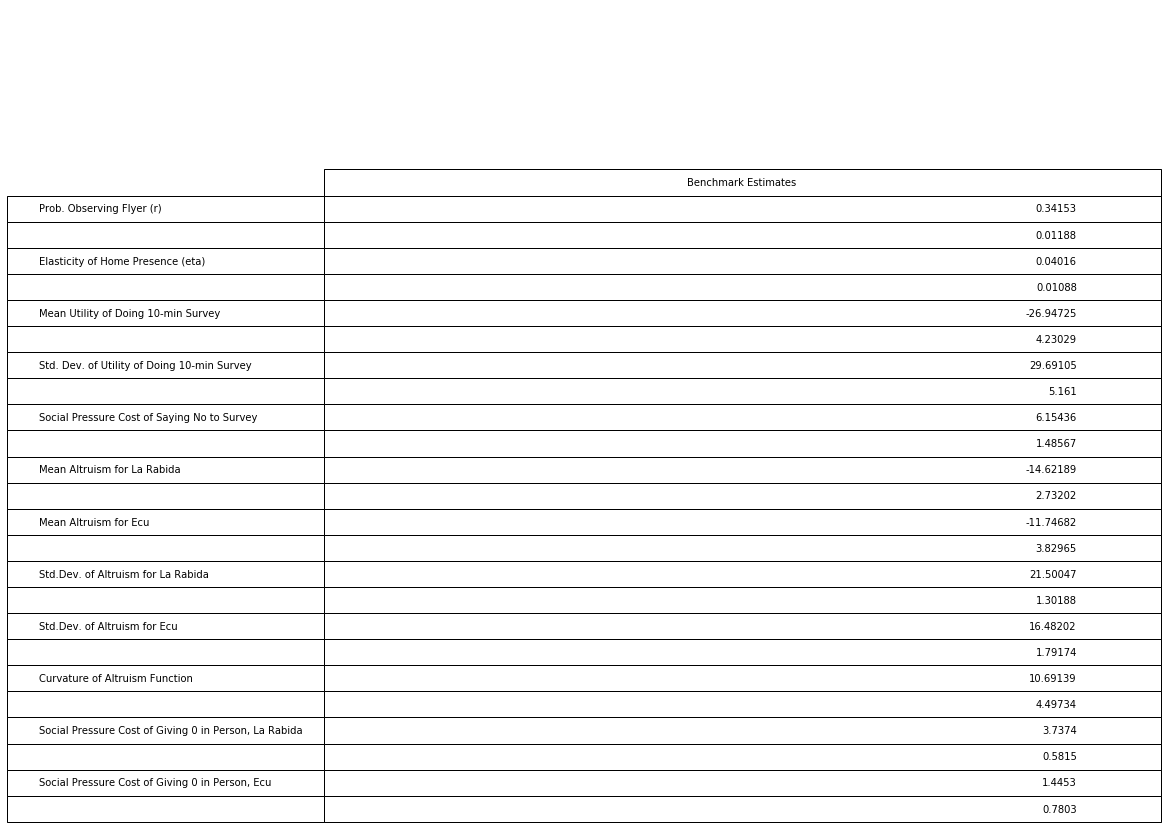

In [358]:
data_est ={"Benchmark Estimates": [round(estimates_and_standard_errors[1][0], 5),
           round(estimates_and_standard_errors[1][1], 5),
           round(estimates_and_standard_errors[2][0], 5),
           round(estimates_and_standard_errors[2][1], 5),
           round(estimates_and_standard_errors[5][0], 5),
           round(estimates_and_standard_errors[5][1], 5),
           round(estimates_and_standard_errors[8][0], 5),
           round(estimates_and_standard_errors[8][1], 5),
           round(estimates_and_standard_errors[11][0], 5),
           round(estimates_and_standard_errors[11][1], 5),
           round(estimates_and_standard_errors[3][0], 5),
           round(estimates_and_standard_errors[3][1], 5),
           round(estimates_and_standard_errors[4][0], 5),
           round(estimates_and_standard_errors[4][1], 5),
           round(estimates_and_standard_errors[6][0], 5),
           round(estimates_and_standard_errors[6][1], 5),
           round(estimates_and_standard_errors[7][0], 5),
           round(estimates_and_standard_errors[7][1], 5),
           round(estimates_and_standard_errors[13][0], 5),
           round(estimates_and_standard_errors[13][1], 5),
           10 * round(estimates_and_standard_errors[9][0], 5),
           10 * round(estimates_and_standard_errors[9][1], 5),
           10 * round(estimates_and_standard_errors[10][0], 5),
           10 * round(estimates_and_standard_errors[10][1], 5)]}
index = ["Prob. Observing Flyer (r)",
        "",
        "Elasticity of Home Presence (eta)",
        "",
        "Mean Utility of Doing 10-min Survey",
        "",
         "Std. Dev. of Utility of Doing 10-min Survey",
        "",
        "Social Pressure Cost of Saying No to Survey",
        "",
        "Mean Altruism for La Rabida",
        "",
         "Mean Altruism for Ecu",
        "",
        "Std.Dev. of Altruism for La Rabida",
        "",
        "Std.Dev. of Altruism for Ecu",
        "",
        "Curvature of Altruism Function",
        "",
        "Social Pressure Cost of Giving 0 in Person, La Rabida",
        "",
        "Social Pressure Cost of Giving 0 in Person, Ecu",
        ""]
df_param = pd.DataFrame(data = data_est, index = index,
                           columns = ["Parameters", "Benchmark Estimates"])
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(111)
ax.table(cellText = df_param.values,
          rowLabels = df_param.index,
          colLabels = df_param.columns,
          loc = "center", 
          colWidths=[1 for x in df_param.columns],
          bbox=[0, -1.5, 1.5, 2])

ax.axis("off")

plt.savefig('Estimates_param.png', dpi = "figure", format = "png")

In [424]:
df_param.index.name = "Parameters"

In [426]:
df_param.to_csv("df_param.csv")

In [447]:
# Table 6 - Decomposition of Giving and Welfare

data6 = {"Panel": ["Share of Givers who would Give wth Social Pressure",
                   "",
                  "Share of Amount that would be Given wth Social Pressure",
                   "",
                  "Share of Givers who Seek the Fund-Raiser (Happy-Givers)",
                  "",
                  "Increase in Answering the Door due to Altruism",
                  "",
                  "Decrease in Answering the Door due to Social Pressure",
                  "",
                  "Welfare per Household Contacted (in $), No-Flyer",
                  "",
                  "Welfare per Household Contacted (in $), Flyer",
                  "",
                  "Welfare per Household Contacted (in $), Opt-Out",
                  ""],
    "Benchmark-Estimates, La Rabida": [round(proportion_givers_and_ses[0][0], 5),
                                           round(proportion_givers_and_ses[0][1], 5),
                                           round(agg_giv_and_ses[2][0], 5),
                                           round(agg_giv_and_ses[2][1], 5),
                                           round(proportion_fundraiserseeker_and_ses[0][0], 5),
                                           round(proportion_fundraiserseeker_and_ses[0][1], 5),
                                           round(avg_utility_inc_and_ses[0][0], 5),
                                           round(avg_utility_inc_and_ses[0][1], 5),
                                           -round(avg_utility_dec_and_ses[0][0], 5),
                                           round(avg_utility_dec_and_ses[0][1], 5),
                                           round(no_flyer_util_and_ses[0][0], 5),
                                           round(no_flyer_util_and_ses[0][1], 5),
                                           round(flyer_util_and_ses[0][0], 5),
                                           round(flyer_util_and_ses[0][1], 5),
                                           round(opt_out_util_and_ses[0][0], 5),
                                           round(opt_out_util_and_ses[0][1], 5)],
         "Benchmark-Estimates, Ecu":      [round(proportion_givers_and_ses[1][0], 5),
                                           round(proportion_givers_and_ses[1][1], 5),
                                           round(agg_giv_and_ses[5][0], 5),
                                           round(agg_giv_and_ses[5][1], 5),
                                           round(proportion_fundraiserseeker_and_ses[1][0], 5),
                                           round(proportion_fundraiserseeker_and_ses[1][1], 5),
                                           round(avg_utility_inc_and_ses[1][0], 5),
                                           round(avg_utility_inc_and_ses[1][1], 5),
                                           -round(avg_utility_dec_and_ses[1][0], 5),
                                           round(avg_utility_dec_and_ses[1][1], 5),
                                           round(no_flyer_util_and_ses[1][0], 5),
                                           round(no_flyer_util_and_ses[1][1], 5),
                                           round(flyer_util_and_ses[1][0], 5),
                                           round(flyer_util_and_ses[1][1], 5),
                                           round(opt_out_util_and_ses[1][0], 5),
                                           round(opt_out_util_and_ses[1][1], 5)],
        }
df_panels = pd.DataFrame(data = data6)

In [449]:
df_panels.to_csv("df_panel.csv")

---
# 2. Sensitivity Analysis (Andrews et al., 2017) <a class="anchor" id="sensitivity"></a>
---

In [151]:
plug_in_sensitivity = - inv(np.matmul(DFDY_CSD1.T, W) @ DFDY_CSD1)  @ DFDY_CSD1.T @ W

### $1/100$th of the Absolute Values of Plug-In Sensitivity of the social pressure cost of soliciting a donation for the East Carolina Hazard Center (ECU)

In [153]:
# Since calculation is based on parameter estimation, social pressure cost for ECU isthe 10th
# parameter in the vector, hence we will be taking the 10th row in that matrix. 
PIS_SP_s = abs((1/100) * plug_in_sensitivity[10, :])

### Un-scaled Plug-In-Sensitivity for Social Pressure Cost in ECU

In [158]:
# Un-scaled Plug-In-Sensitivity for Social Pressure Cost in ECU
PIS_SP = plug_in_sensitivity[10, :]

### Asymptotic Bias in Social Pressure Cost in ECU

In [157]:
x1 = (PIS_SP[48] * (0.0390 - 0.0056) + PIS_SP[50] * (0.0451 - 0.0056) + PIS_SP[46] * (0.0422 - 0.0051))
x2 = (PIS_SP[44] * (0 - 0.0206) + PIS_SP[40] * (0 - 0.027) + PIS_SP[42] * (0 - 0.0265))
x3 = (PIS_SP[56] * (0 - 0.008) + PIS_SP[52] * (0 - 0.008) + PIS_SP[54] * (0 - 0.0098))
x4 = (PIS_SP[62] * (0 - 0.003) + PIS_SP[58] * (0 - 0.0021) + PIS_SP[60] * (0 - 0.003))
x5 = (PIS_SP[68] * (0 - 0) + PIS_SP[64] * (0 - 0) + PIS_SP[66] * (0 - 0))
# Asymptotic Bias
0.01 * (x1 + x2 + x3 + x4 + x5)

0.008292550766358368

### Figure:  Scaled Plug-In-Sensitivity for Social Pressure Cost of the ECU

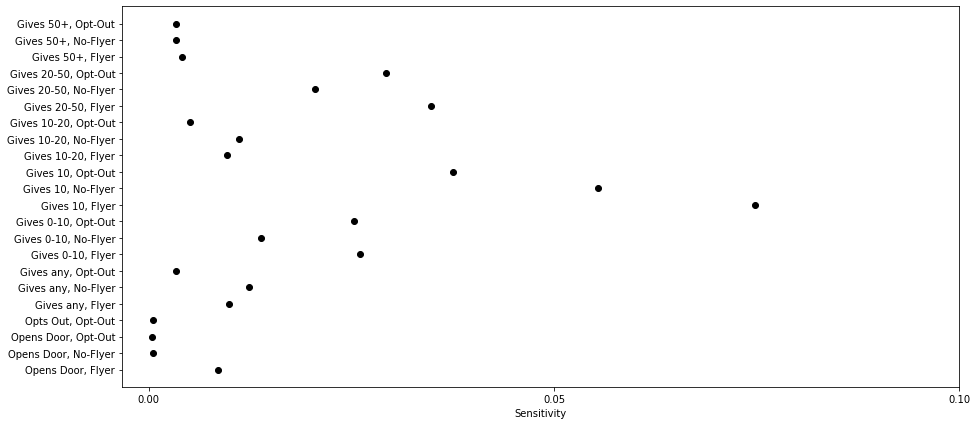

In [407]:
x_values = [PIS_SP_s[3], PIS_SP_s[1], PIS_SP_s[5], PIS_SP_s[21],
            PIS_SP_s[13], PIS_SP_s[11], PIS_SP_s[15],
            PIS_SP_s[44], PIS_SP_s[40], PIS_SP_s[42], PIS_SP_s[50],
            PIS_SP_s[46], PIS_SP_s[48], PIS_SP_s[56], PIS_SP_s[52], 
            PIS_SP_s[54], PIS_SP_s[62], PIS_SP_s[58], PIS_SP_s[60],
            PIS_SP_s[68], PIS_SP_s[64], PIS_SP_s[66]]
y_values = ["Opens Door, Flyer", "Opens Door, No-Flyer", "Opens Door, Opt-Out", 
            "Opts Out, Opt-Out", "Gives any, Flyer", "Gives any, No-Flyer",
            "Gives any, Opt-Out", "Gives 0-10, Flyer", "Gives 0-10, No-Flyer",
           "Gives 0-10, Opt-Out", "Gives 10, Flyer", "Gives 10, No-Flyer",
           "Gives 10, Opt-Out", "Gives 10-20, Flyer", "Gives 10-20, No-Flyer",
           "Gives 10-20, Opt-Out", "Gives 20-50, Flyer", "Gives 20-50, No-Flyer", 
           "Gives 20-50, Opt-Out", "Gives 50+, Flyer", "Gives 50+, No-Flyer", "Gives 50+, Opt-Out"]
y_axis = np.arange(0, 22, 1)
plt.figure(figsize=(15,7))
plt.plot(x_values, y_axis, 'o', color = 'black')
plt.yticks(y_axis, y_values)
plt.xticks([0, 0.05, 0.1])
plt.xlabel("Sensitivity")
plt.savefig("sensitivity.png", dpi = "figure", format = "png")
plt.show()

### Scaled and Unscaled Plug-In-Sensitivity for the Mean of Altruism Parameter for ECU

In [174]:
PIS_MU_s = abs((1/100) * plug_in_sensitivity[4, :])
# Un-scaled Plug-In-Sensitivity for Mean Altruism in ECU
PIS_MU = plug_in_sensitivity[4, :]

### Asymptotic bias in Mean Altruism parameter of ECU

In [175]:
Asymp_Bias_Mu = 0.01 * (PIS_MU[42] * (0 - 0.0265) + PIS_MU[48] * (0 - 0.0056) + PIS_MU[54] * ((0.039/2) - 0.0098) + \
                PIS_MU[60] * ((0.039/2) - 0.003) + PIS_MU[66] * (0 - 0))
Asymp_Bias_Mu

-0.0644783560369822

### Figure:  Scaled Plug-In-Sensitivity for Mean of Altruism Parameter for ECU

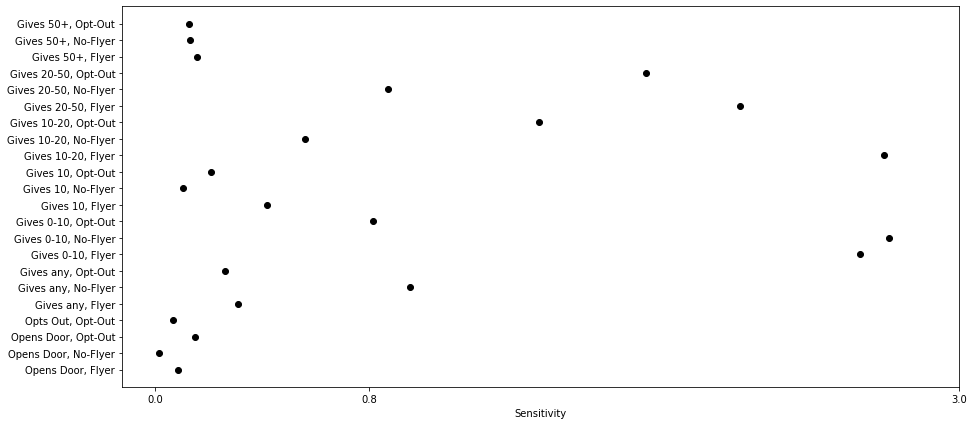

In [408]:
xM_values = [PIS_MU_s[3], PIS_MU_s[1], PIS_MU_s[5], PIS_MU_s[21],
            PIS_MU_s[13], PIS_MU_s[11], PIS_MU_s[15],
            PIS_MU_s[44], PIS_MU_s[40], PIS_MU_s[42], PIS_MU_s[50],
            PIS_MU_s[46], PIS_MU_s[48], PIS_MU_s[56], PIS_MU_s[52], 
            PIS_MU_s[54], PIS_MU_s[62], PIS_MU_s[58], PIS_MU_s[60],
            PIS_MU_s[68], PIS_MU_s[64], PIS_MU_s[66]]
yM_values = ["Opens Door, Flyer", "Opens Door, No-Flyer", "Opens Door, Opt-Out", 
            "Opts Out, Opt-Out", "Gives any, Flyer", "Gives any, No-Flyer",
            "Gives any, Opt-Out", "Gives 0-10, Flyer", "Gives 0-10, No-Flyer",
           "Gives 0-10, Opt-Out", "Gives 10, Flyer", "Gives 10, No-Flyer",
           "Gives 10, Opt-Out", "Gives 10-20, Flyer", "Gives 10-20, No-Flyer",
           "Gives 10-20, Opt-Out", "Gives 20-50, Flyer", "Gives 20-50, No-Flyer", 
           "Gives 20-50, Opt-Out", "Gives 50+, Flyer", "Gives 50+, No-Flyer", "Gives 50+, Opt-Out"]
yM_axis = np.arange(0, 22, 1)
plt.figure(figsize=(15,7))
plt.plot(xM_values, yM_axis, 'o', color = 'black')
plt.yticks(yM_axis, yM_values)
plt.xticks([0, 0.8, 3])
plt.xlabel("Sensitivity")
plt.savefig("sensitivity_mu.png", dpi = "figure", format = "png")
plt.show()

### Plug-In-Sensitivity Values in a Table

In [229]:
df = pd.DataFrame(list(zip(yM_values, PIS_SP, PIS_MU)), 
                  columns = ['Moments', 'Sensitivty of S{}{}{}'.format('\u1d31', '\u1d9c', '\u1d58'), 
                             'Sensitivity of \u03BC{}{}{}'.format('\u1d31', '\u1d9c', '\u1d58')])

In [231]:
df.to_csv("PIS_table.csv")

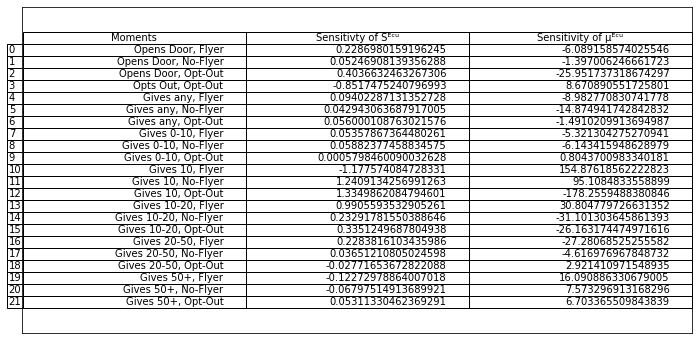

In [245]:
plt.figure(figsize=(12,6))
ax = plt.subplot(111, frame_on=True)
ax.xaxis.set_visible(False)  
ax.yaxis.set_visible(False)  

table(ax, df, loc = 'center')
plt.savefig('PIS_table.png', dpi = "figure", format = "png")

---
# 3. Local Partial-Derivative-Based Sensitivity Analysis <a class="anchor" id="extension"></a>
---

---
## Share of Not Happy Givers
---

In [410]:
# Curvature Altruism Parameter
Gi_lar = bestEstimate[13]
# Mean Altruism Parameter for La Rabida Charity
mu_lar = bestEstimate[3]
# Standard Deviation of Altruism for La Rabida Charity
sigma_lar = bestEstimate[6]
# Social Pressure Cost parameter - different values
S_lar = np.linspace(0, 1)

# Partial-Derivative wrt Social Pressure Cost Parameter - Share of Givers
f = (1 - scipy.stats.norm.cdf((Gi_lar - mu_lar) / sigma_lar))
g = (1-scipy.stats.norm.cdf(((1 - S_lar)*Gi_lar-mu_lar)/sigma_lar))
g_prime = -(np.exp((((1-S_lar)*Gi_lar-mu_lar)/sigma_lar)**2 / (-2)) / (sigma_lar * np.sqrt(2 * np.pi))) * (-Gi_lar)
deriv = - f * g_prime / g**2

# Share of Givers for different values of Social Pressure Cost Parameter
pg_lar = []
for i in S_lar:
    p = (1-scipy.stats.norm.cdf((Gi_lar-\
                                        mu_lar)/sigma_lar))/(1-scipy.stats.norm.cdf(((1 - i)*Gi_lar-mu_lar)/sigma_lar))  
    pg_lar.append(p)

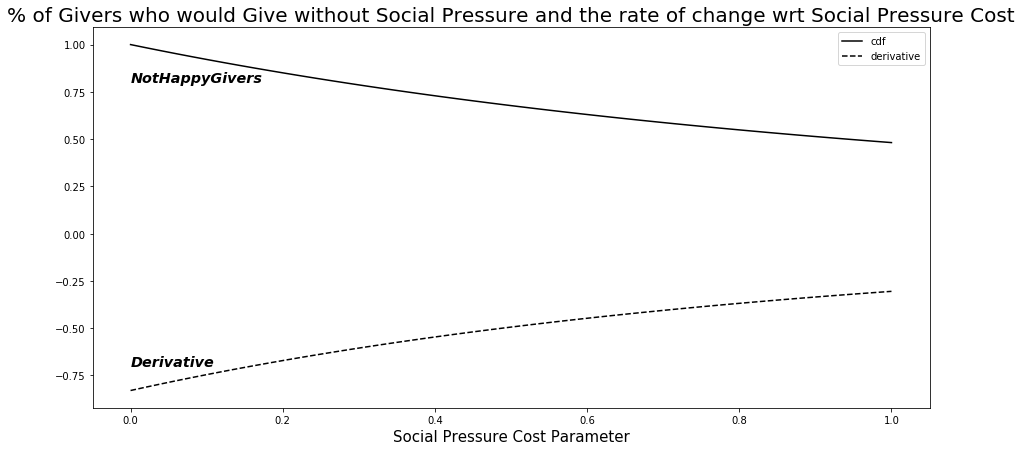

In [413]:
plt.figure(figsize=(15,7))
plt.plot(list(S_lar), pg_lar, label = "cdf", linestyle='-', color = 'black')
plt.plot(list(S_lar), list(deriv), label = "derivative", linestyle='--', color= 'black')
plt.text(0, 0.8, 'NotHappyGivers', fontsize = 'x-large', fontweight = 'bold', fontstyle = 'italic')
plt.text(0, -0.7, 'Derivative', fontsize = 'x-large', fontweight = 'bold', fontstyle = 'italic')
plt.legend(loc = 1)
plt.title("% of Givers who would Give without Social Pressure and the rate of change wrt Social Pressure Cost", fontsize = 20)
plt.xlabel("Social Pressure Cost Parameter", fontsize = 15)
plt.savefig("figure451.png", dpi = "figure", format = "png")
plt.show()

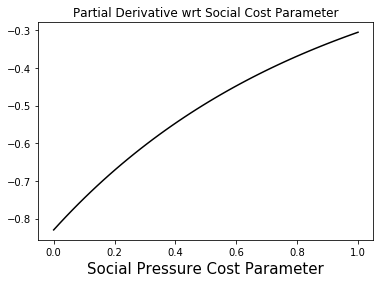

In [414]:
plt.plot(list(S_lar), list(deriv), label = "derivative", color = 'black')
plt.title("Partial Derivative wrt Social Cost Parameter")
plt.xlabel("Social Pressure Cost Parameter", fontsize = 15)
plt.savefig("figure452.png", dpi = "figure", format = "png")
plt.show()

---
## Share of Happy Givers
---

In [415]:
S_lar = bestEstimate[9]
gs_lar = 10
aMinMin_lar = (1 - S_lar)*Gi_lar
aMin_lar = (1 - S_lar)* (Gi_lar + gs_lar)
aPlus_lar = Gi_lar + gs_lar
a0_lar = gs_lar / np.log(1 + (gs_lar/Gi_lar))

In [416]:
# Across different values for Social Pressure
S_lar = np.linspace(0, 1)
Gi_lar = bestEstimate[13]
# Partial-Derivative
f3 = (1-scipy.stats.norm.cdf((gs_lar / np.log(1 + (gs_lar/Gi_lar))-mu_lar)/sigma_lar))
g3 = (1-scipy.stats.norm.cdf(((1-S_lar)*Gi_lar-mu_lar)/sigma_lar))
g_prime3 = -(np.exp((((1-S_lar)*Gi_lar-mu_lar)/sigma_lar)**2 / (-2)) / (sigma_lar * np.sqrt(2 * np.pi))) * (-Gi_lar)
deriv3 = (-f3 * g_prime3) / g**2

# Share of Happy Givers given Social pressure Cost parameter
pg_lar3 = []
for i in S_lar:
    
    p = (1-scipy.stats.norm.cdf(((gs_lar / np.log(1 + (gs_lar / Gi_lar)))-\
                                          mu_lar)/sigma_lar))/(1-scipy.stats.norm.cdf(((1-i)*Gi_lar-mu_lar)/sigma_lar))
    pg_lar3.append(p)

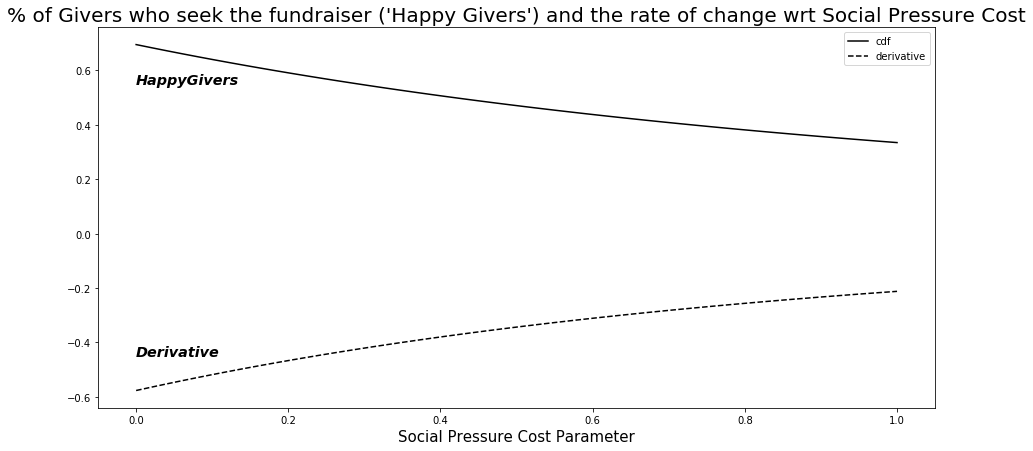

In [418]:
plt.figure(figsize=(15,7))
plt.plot(list(S_lar), pg_lar3, label = "cdf", linestyle = '-', color = 'black')
plt.plot(list(S_lar), list(deriv3), label = "derivative", linestyle = '--', color = 'black')
plt.text(0, 0.55, "HappyGivers", fontsize = 'x-large', fontweight = 'bold', fontstyle = 'italic')
plt.text(0, -0.45, "Derivative", fontsize = 'x-large', fontweight = 'bold', fontstyle = 'italic')
plt.legend(loc = 1)
plt.title("% of Givers who seek the fundraiser ('Happy Givers') and the rate of change wrt Social Pressure Cost", fontsize = 20)
plt.xlabel("Social Pressure Cost Parameter", fontsize = 15)
plt.savefig("figure453.png", dpi = "figure", format = "png")
plt.show()

In [419]:
# Across different Curvature Altruism Paramater values
Gi_lar = np.linspace(1, 100)
S_lar = bestEstimate[9]
# For gs = 10, partial-derivative wrt Curvature Paramter
gs_lar1 = 10
f1 = (1-scipy.stats.norm.cdf((gs_lar1 / np.log(1 + (gs_lar1/Gi_lar))-mu_lar)/sigma_lar))
g1 = (1-scipy.stats.norm.cdf(((1-S_lar)*Gi_lar-mu_lar)/sigma_lar))
x_prime1 = (gs_lar1**2 / (np.log(10) * Gi_lar**2 * (1 +(gs_lar1/Gi_lar)))) / np.log(1 + (gs_lar1/Gi_lar))**2
f_prime1 = -(np.exp(((gs_lar1 / np.log(1 + (gs_lar1/Gi_lar))- \
            mu_lar)/sigma_lar)**2 / (-2)) / (sigma_lar * np.sqrt(2 * np.pi))) * x_prime1
g_prime1 = -(np.exp((((1-S_lar)*Gi_lar-mu_lar)/sigma_lar)**2 / (-2)) / (sigma_lar * np.sqrt(2 * np.pi))) * (1 - S_lar)
deriv1 = (f_prime1 * g1 - g_prime1 * f1) / g1**2

# For gs = 50, partial-derivative wrt Curvature Paramter
gs_lar2 = 50
f2 = (1-scipy.stats.norm.cdf((gs_lar2 / np.log(1 + (gs_lar2/Gi_lar))-mu_lar)/sigma_lar))
g2 = (1-scipy.stats.norm.cdf(((1-S_lar)*Gi_lar-mu_lar)/sigma_lar))
x_prime2 = (gs_lar2**2 / (np.log(10) * Gi_lar**2 * (1 +(gs_lar2/Gi_lar)))) / np.log(1 + (gs_lar2/Gi_lar))**2
f_prime2 = -(np.exp(((gs_lar2 / np.log(1 + (gs_lar2/Gi_lar))- \
            mu_lar)/sigma_lar)**2 / (-2)) / (sigma_lar * np.sqrt(2 * np.pi))) * x_prime2
g_prime2 = -(np.exp((((1-S_lar)*Gi_lar-mu_lar)/sigma_lar)**2 / (-2)) / (sigma_lar * np.sqrt(2 * np.pi))) * (1 - S_lar)
deriv2 = (f_prime2 * g2 - g_prime2 * f2) / g2**2

In [420]:
# Share of Happy Givers given different gs
pg_lar1 = []
for i in Gi_lar:
    
    p = (1-scipy.stats.norm.cdf(((gs_lar1 / np.log(1 + (gs_lar1 / i)))-\
                                          mu_lar)/sigma_lar))/(1-scipy.stats.norm.cdf(((1-S_lar)*i-mu_lar)/sigma_lar))
    pg_lar1.append(p)
pg_lar2 = []
for i in Gi_lar:
    
    p = (1-scipy.stats.norm.cdf(((gs_lar2 / np.log(1 + (gs_lar2 / i)))-\
                                          mu_lar)/sigma_lar))/(1-scipy.stats.norm.cdf(((1-S_lar)*i-mu_lar)/sigma_lar))
    pg_lar2.append(p)  

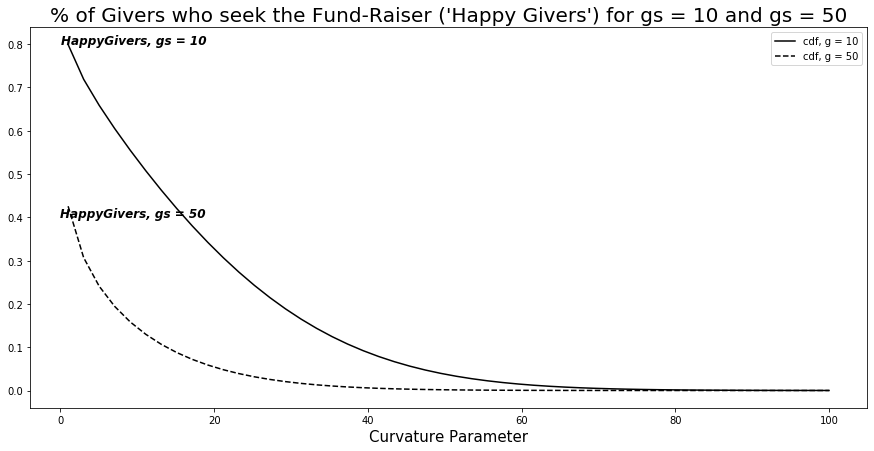

In [421]:
plt.figure(figsize=(15,7))
plt.plot(list(Gi_lar), pg_lar1, label = "cdf, g = 10", linestyle = '-', color = 'black')
plt.plot(list(Gi_lar), pg_lar2, label = "cdf, g = 50", linestyle = '--', color = 'black')
#plt.plot(list(Gi_lar), list(deriv1), label = "derivative, g = 10")
#plt.plot(list(Gi_lar), list(deriv2), label = "derivative, g = 50")
plt.text(0.1, 0.8, "HappyGivers, gs = 10", fontsize = 'large', fontweight = 'bold', fontstyle = 'italic')
plt.text(0, 0.4, "HappyGivers, gs = 50", fontsize = 'large', fontweight = 'bold', fontstyle = 'italic')
#plt.text(0, 0.1, "Deriv., gs = 10", fontsize = 'large', fontweight = 'bold', fontstyle = 'italic')
#plt.text(0, -0.001, "Deriv., gs = 50", fontsize = 'large', fontweight = 'bold', fontstyle = 'italic')
plt.legend(loc = 1)
plt.title("% of Givers who seek the Fund-Raiser ('Happy Givers') for gs = 10 and gs = 50", fontsize = 20)
plt.xlabel("Curvature Parameter", fontsize = 15)
plt.savefig("figure454.png", dpi = "figure", format = "png")
plt.show()

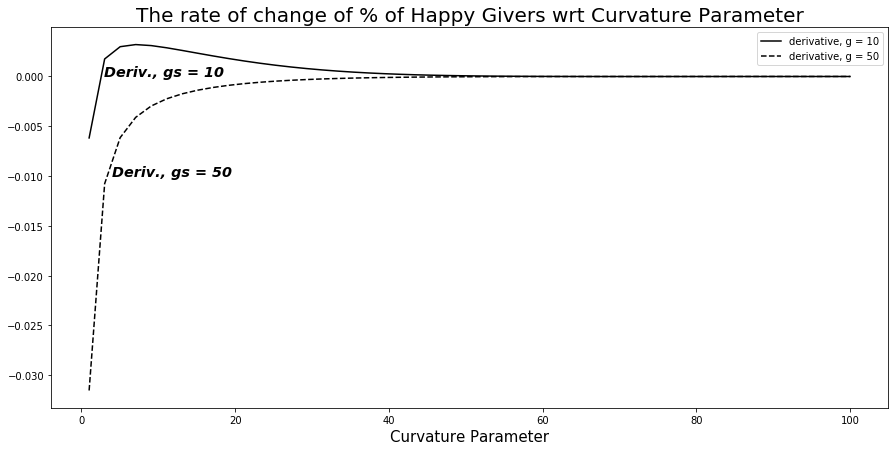

In [422]:
plt.figure(figsize=(15,7))
plt.plot(list(Gi_lar), deriv1, label = "derivative, g = 10", linestyle = '-', color= 'black')
plt.plot(list(Gi_lar), deriv2, label = "derivative, g = 50", linestyle = '--', color= 'black')
plt.text(3, 0, "Deriv., gs = 10", fontsize = 'x-large', fontweight = 'bold', fontstyle = 'italic')
plt.text(4, -0.01, "Deriv., gs = 50", fontsize = 'x-large', fontweight = 'bold', fontstyle = 'italic')
plt.title("The rate of change of % of Happy Givers wrt Curvature Parameter", fontsize = 20)
plt.xlabel("Curvature Parameter", fontsize = 15)
plt.legend(loc = 1)
plt.savefig("figure455.png", dpi = "figure", format = "png")
plt.show()